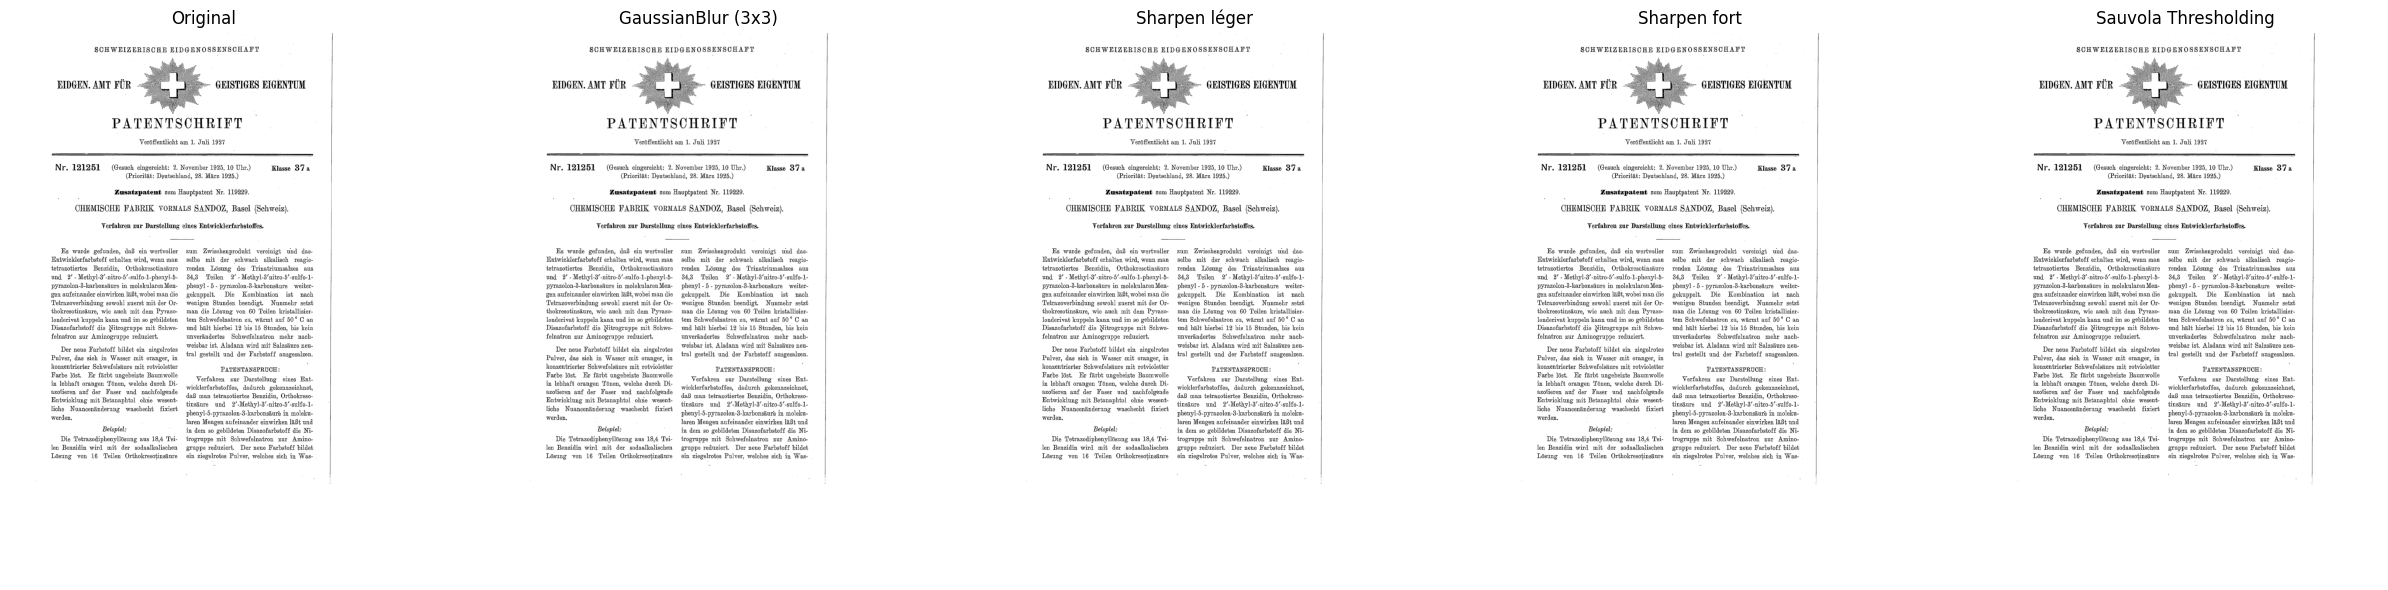

🧾 OCR résultats comparatifs:

— Original —
SCHWEIZERISCHE EIDGENOSSENSCHAFT

EIDGEN. AMT FÜR

GEISTIGES EIGENTUM

PATENTSCHRIFT

Veröffentlicht am 1. Juli 1927

Nr. 121251

(Gesuch eingereicht: 2. November 1925, 10 Uhr.)

Klasse 37 a

(Priorität: Deutschland, 28: März 1925.)

Zusatzpatent zum Hauptpatent Nr. 119229.
CHEMISCHE FABRIK VORMALS SANDOZ, Basel (Schweiz).

Verfahren zur Darstellung eines Entwicklerfarbstoffes,

Es wurde gefunden, daß ein wertvoller
Enntwicklerfarbstoff erhalten wird, wenn man
tetrazotiertes Benzidin, Orthokreso

— Flouté (GaussianBlur 3x3) —
SCHWEIZERISCHE EIDGENOSSENSCHAFT

Veröffentlicht am 1. Juli 1927

Nr. 121251

(Gesuch eingereicht: 2. November 1925, 10 Uhr.)

Klasse 37a

(Priorität: Deutschland, 28: März 1925.)

Zusatzpatent zum Hauptpatent Nr. 119229.
CHEMISCHE FABRIK VORMALS SANDOZ, Basel (Schweiz).

Verfahren zur Darstellung eines Entwicklerfarbstoffes.

Es wurde gefunden, daß ein wertvoller
Enntwicklerfarbstoff erhalten wird, wenn man
tetrazotierte

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
from skimage import filters, img_as_ubyte
import numpy as np

def sauvola_threshold(gray, window=25, k=0.2):
    thresh_sauvola = filters.threshold_sauvola(gray, window_size=window, k=k)
    binary = gray > thresh_sauvola
    return img_as_ubyte(binary)

# --- 1️⃣ Charger la première page du PDF ---
pdf_path = "data/raw_pdf/CH-121251-A_full.pdf"
page = convert_from_path(pdf_path, dpi=300, first_page=1, last_page=1)[0]
gray = np.array(page.convert("L"))

# --- 2️⃣ Fonctions utiles ---
def unsharp_mask(gray, sigma=1.0, strength=1.5):
    blur = cv2.GaussianBlur(gray, (0, 0), sigma)
    return cv2.addWeighted(gray, 1 + strength, blur, -strength, 0)

def show_images(images, titles, cmap="gray"):
    n = len(images)
    plt.figure(figsize=(5*n, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- 3️⃣ Versions de traitement ---
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
sharp_soft = unsharp_mask(gray, sigma=1.0, strength=1.0)
sharp_strong = unsharp_mask(gray, sigma=1.0, strength=2.5)
sauvola = sauvola_threshold(gray, window=25, k=0.3)
# --- 4️⃣ OCR sur chaque version ---
ocr_orig = pytesseract.image_to_string(gray, lang="deu")
ocr_blur = pytesseract.image_to_string(blurred, lang="deu")
ocr_sharp_soft = pytesseract.image_to_string(sharp_soft, lang="deu")
ocr_sharp_strong = pytesseract.image_to_string(sharp_strong, lang="deu")

# --- 5️⃣ Affichage comparatif ---
show_images(
    [gray, blurred, sharp_soft, sharp_strong, sauvola],
    ["Original", "GaussianBlur (3x3)", "Sharpen léger", "Sharpen fort","Sauvola Thresholding"]
)

# --- 6️⃣ Afficher les textes OCRisés ---
print("🧾 OCR résultats comparatifs:\n")
print("— Original —")
print(ocr_orig[:500])
print("\n— Flouté (GaussianBlur 3x3) —")
print(ocr_blur[:500])
print("\n— Sharpen léger —")
print(ocr_sharp_soft[:500])
print("\n— Sharpen fort —")
print(ocr_sharp_strong[:500])


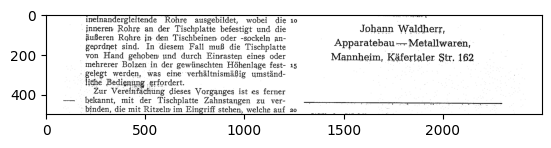

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("data/gold_standard_DE/PNGs_extracted/DE-1005702-B.png")
plt.imshow(img.crop((0, 1300, 2500, 1800)))   # zone bas du nom
plt.show()


In [4]:
from doclayout_yolo import YOLOv10
from huggingface_hub import hf_hub_download
import fitz
import numpy as np
from PIL import Image, ImageDraw


path = hf_hub_download(
    "juliozhao/DocLayout-YOLO-DocStructBench",
    "doclayout_yolo_docstructbench_imgsz1024.pt"
)
model = YOLOv10(str(path))

doc = fitz.open("data/gold_standard_DE/PNGs_extracted/DE-1777078-A1.pdf")
page = doc.load_page(0)
pix = page.get_pixmap(dpi=300)
img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)

res = model.predict(np.array(img))[0]

draw = ImageDraw.Draw(img)
for box, cls_id in zip(res.boxes.xyxy, res.boxes.cls):
    x1,y1,x2,y2 = map(int, box.tolist())
    draw.rectangle([x1,y1,x2,y2], outline="red", width=3)

img.show()


/Users/delville/code/Just-PH/patent_pipeline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



0: 1024x736 1 title, 5 plain texts, 2 abandons, 595.4ms
Speed: 3.8ms preprocess, 595.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)


In [5]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
from patent_pipeline.patent_ocr.ocr_utils import preprocess_image
preproc_method = "otsu"
import cv2
import numpy as np
from PIL import Image


def segment_patent_page_universal(pil_img):
    """
    Segmentation robuste pour tous les brevets DE (Auslegeschrift, Patentschrift, Offenlegungsschrift).
    Fonction unique.
    """

    # ---------------------------------------------------------
    # 1) Chargement / grayscale
    # ---------------------------------------------------------
    img = np.array(pil_img)
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    H, W = gray.shape

    # ---------------------------------------------------------
    # 2) Binarisation hybride (Otsu + adaptatif)
    # ---------------------------------------------------------
    _, th_otsu = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    th_sauv = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        45, 15
    )

    # union robuste
    th = cv2.bitwise_or(th_otsu, th_sauv)

    # ---------------------------------------------------------
    # 3) Détection automatique colonne unique / double colonnes
    # ---------------------------------------------------------
    proj = th.sum(axis=0)
    gaps = np.where(proj < 0.1 * np.max(proj))[0]
    is_two_cols = len(gaps) > W * 0.02   # si plus de 2% de colonnes quasi vides → 2 colonnes

    # structurant adaptatif
    if is_two_cols:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 25))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (65, 35))

    morph = cv2.dilate(th, kernel, iterations=2)

    # ---------------------------------------------------------
    # 4) Virer les lignes horizontales
    # ---------------------------------------------------------
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (W//12, 3))
    lines = cv2.morphologyEx(th, cv2.MORPH_OPEN, hor_kernel)

    morph = cv2.bitwise_and(morph, cv2.bitwise_not(lines))

    # ---------------------------------------------------------
    # 5) Contours
    # ---------------------------------------------------------
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    blocks = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        if w*h < 5000:      # bruit trop petit
            continue
        if h < 25 or w < 60:
            continue
        if w > W*0.97:      # ligne horizontale résiduelle
            continue

        blocks.append([x, y, x+w, y+h])

    # ---------------------------------------------------------
    # 6) Remove nested
    # ---------------------------------------------------------
    blocks = sorted(blocks, key=lambda b: (b[1], b[0]))
    filtered = []
    for i,b in enumerate(blocks):
        xi, yi, xa, ya = b
        inside = False
        for j,b2 in enumerate(blocks):
            if i == j: continue
            x1,y1,x2,y2 = b2
            if xi>=x1 and yi>=y1 and xa<=x2 and ya<=y2:
                inside=True; break
        if not inside:
            filtered.append(b)

    return filtered


def remove_nested_boxes(blocks, margin=3):
    final = []
    for i,b in enumerate(blocks):
        x1,y1,x2,y2 = b
        inside = False
        for j,B in enumerate(blocks):
            if i==j: continue
            X1,Y1,X2,Y2 = B
            if x1>=X1-margin and y1>=Y1-margin and x2<=X2+margin and y2<=Y2+margin:
                inside=True
                break
        if not inside:
            final.append(b)
    return final



doc_paths =[
        "data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png",
        "data/gold_standard_DE/PNGs_extracted/DE-1271093-C2.png",
        "data/gold_standard_DE/PNGs_extracted/DE-953673-C.png",
        "data/gold_standard_DE/PNGs_extracted/DE-1545252-A1.pdf"
        ]

for doc_path in doc_paths:

    doc = Path(doc_path)
    if doc.suffix.lower() == ".pdf":
        page = fitz.open(str(doc)).load_page(0)
        pix = page.get_pixmap(dpi=300)
        raw_img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    else:
        raw_img = Image.open(doc).convert("RGB")

    img = preprocess_image(raw_img, method=preproc_method)
    boxes = segment_patent_page_universal(img)
    boxes = remove_nested_boxes(boxes)
    img_rgb = img.convert("RGB")
    draw = ImageDraw.Draw(img_rgb)
    for (x1,y1,x2,y2) in boxes:
        draw.rectangle([x1,y1,x2,y2], outline="red", width=4)

    img_rgb.show()


In [6]:
import numpy as np
import cv2
from PIL import Image, ImageOps
from pathlib import Path
import fitz
import matplotlib.pyplot as plt
from typing import List, Tuple

# --- REMARQUE IMPORTANTE ---
# Les fonctions deskew_image, sauvola_threshold, niblack_threshold
# doivent être définies ou importées pour que preprocess_ocr fonctionne.
# J'ai laissé les appels commentés dans preprocess_ocr.

# -----------------------------------------------------------
# I. FONCTIONS DE PRÉ-TRAITEMENT ET DE POST-TRAITEMENT
# -----------------------------------------------------------

def preprocess_segmentation(pil_img: Image.Image) -> Image.Image:
    """
    Binarisation adaptative et nettoyage du bruit initial.
    Retourne une image binaire (0 ou 255).
    """
    gray = np.array(pil_img.convert("L"))
    # 2. OTSU global : stable pour du bruit isolé
    _, binary = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 2. Petit opening pour grains 1-2 px
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel3)

    # 3. Optionnel : ouvrir un tout petit plus
    kernel5 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    clean = cv2.morphologyEx(clean, cv2.MORPH_OPEN, kernel5)
    return Image.fromarray(clean)

def filter_nested_boxes(boxes: List[List[int]], margin: int = 3) -> List[List[int]]:
    """
    Supprime les boîtes strictement contenues dans une autre (avec marge).
    Tri initial par aire décroissante pour l'optimisation.
    """
    keep = [True] * len(boxes)
    # Tri par aire décroissante
    sorted_boxes = sorted(enumerate(boxes), key=lambda x: (x[1][2]-x[1][0])*(x[1][3]-x[1][1]), reverse=True)

    for i_idx, (x1, y1, x2, y2) in sorted_boxes:
        for j_idx, (X1, Y1, X2, Y2) in sorted_boxes:
            if i_idx == j_idx or not keep[i_idx]: continue

            # Si la boîte i est significativement plus petite que j
            if (x2 - x1) * (y2 - y1) >= (X2 - X1) * (Y2 - Y1) and i_idx != j_idx: continue

            # Condition d'inclusion floue
            inside = (x1 >= X1 - margin and y1 >= Y1 - margin and
                      x2 <= X2 + margin and y2 <= Y2 + margin)

            if inside:
                keep[i_idx] = False
                break

    # Reconstruit la liste des boîtes non incluses en utilisant l'index original
    original_boxes = [box for _, box in sorted_boxes]
    return [b for b, k in zip(original_boxes, keep) if k]

def merge_overlapping_blocks(blocks: List[List[int]], iou_thresh: float = 0.15) -> List[List[int]]:
    """
    Fusionne les boîtes qui se chevauchent au-dessus du seuil IoU.
    """
    merged = True
    blocks = blocks.copy()

    while merged:
        merged = False
        new_blocks = []
        used = set()

        for i in range(len(blocks)):
            if i in used: continue
            x1,y1,x2,y2 = blocks[i]

            for j in range(i+1, len(blocks)):
                if j in used: continue
                X1,Y1,X2,Y2 = blocks[j]

                # Calcul de l'intersection
                inter_x1 = max(x1, X1)
                inter_y1 = max(y1, Y1)
                inter_x2 = min(x2, X2)
                inter_y2 = min(y2, Y2)

                inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
                if inter_area == 0: continue

                # Calcul de l'IoU
                areaA = (x2 - x1) * (y2 - y1)
                areaB = (X2 - X1) * (Y2 - Y1)
                union_area = areaA + areaB - inter_area
                iou = inter_area / union_area

                if iou > iou_thresh:
                    # Fusion si l'IoU est dépassé
                    nx1 = min(x1, X1)
                    ny1 = min(y1, Y1)
                    nx2 = max(x2, X2)
                    ny2 = max(y2, Y2)

                    used.add(i)
                    used.add(j)

                    new_blocks.append([nx1, ny1, nx2, ny2])
                    merged = True
                    break

            if i not in used:
                new_blocks.append(blocks[i])

        blocks = new_blocks

    return blocks

def sort_reading_order(boxes: List[List[int]], y_tolerance: int = 20) -> List[List[int]]:
    """
    Tri les boîtes pour l'ordre de lecture naturel (Haut-bas, Gauche-droite).
    """
    boxes.sort(key=lambda b: b[1])

    sorted_boxes = []
    i = 0
    while i < len(boxes):
        row = [boxes[i]]
        j = i + 1
        # Collecte toutes les boîtes sur la même "ligne"
        while j < len(boxes) and abs(boxes[j][1] - boxes[i][1]) < y_tolerance:
            row.append(boxes[j])
            j += 1

        # Trie cette "ligne" de gauche à droite
        row.sort(key=lambda b: b[0])
        sorted_boxes.extend(row)
        i = j
    return sorted_boxes

# -----------------------------------------------------------
# II. NOUVELLE FONCTION DE SEGMENTATION PAR FLOU GAUSSIEN
# -----------------------------------------------------------

def segmentation(binary_img: Image.Image) -> List[List[int]]:
    """
    Segmentation de blocs de texte utilisant le flou Gaussien pour fusionner
    les mots/lignes en gros blocs (colonnes).
    """
    binary = np.array(binary_img)

    # Cas de sécurité si jamais on se retrouve avec du RGB par erreur
    if binary.ndim == 3:
        binary = cv2.cvtColor(binary, cv2.COLOR_RGB2GRAY)

    # Blur massif = fusion mots -> lignes -> paragraphes
    blurred = cv2.GaussianBlur(binary, (41, 41), 0)

    # Seuillage simple
    blocks = (blurred > 200).astype(np.uint8) * 255

    # Contours bruts
    contours, _ = cv2.findContours(blocks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    raw_boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        # Filtres géométriques de base
        if w * h < 1500:
            continue
        if h < 20 or w < 20:
            continue

        ratio = max(w, h) / min(w, h) if min(w, h) > 0 else float("inf")
        if ratio > 15:
            continue  # évite les lignes trop "droites"

        pad = 8
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W, x + w + 2 * pad)
        y2 = min(H, y + h + 2 * pad)

        raw_boxes.append([x1, y1, x2, y2])

    # 7. Post-traitement des boîtes
    non_nested = filter_nested_boxes(raw_boxes, margin=5)
    merged = merge_overlapping_blocks(non_nested, iou_thresh=0.15)
    final_boxes = filter_nested_boxes(merged, margin=5)

    # 8. Tri final en ordre de lecture
    final_sorted = sort_reading_order(final_boxes, y_tolerance=20)

    return raw_boxes

# -----------------------------------------------------------
# III. FONCTIONS OCR (pour référence, dépend des imports)
# -----------------------------------------------------------

def preprocess_ocr(pil_img: Image.Image, method: str = "otsu") -> Image.Image:
    """
    Préprocessing optimisé OCR (à utiliser sur chaque bloc découpé).
    """
    up = pil_img.resize(
        (int(pil_img.width * 1.5), int(pil_img.height * 1.5)),
        Image.LANCZOS
    )

    # 2) Deskew léger (omis car dépend d'une fonction externe)

    # 3) CLAHE
    gray = np.array(up.convert("L"))
    clahe_filter = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe_filter.apply(gray)

    # 4) Binarisation
    if method == "otsu":
        _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # elif method == "sauvola":
    #     bw = sauvola_threshold(gray, window=25, k=0.3)
    # elif method == "niblack":
    #     bw = niblack_threshold(gray, window=25, k=0.8)
    else:
        # Fallback
        _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 5) Autocontrast
    pil_out = Image.fromarray(bw)
    pil_out = ImageOps.autocontrast(pil_out)

    return pil_out

In [7]:
import fitz
from pathlib import Path
from PIL import Image, ImageDraw
import cv2
import numpy as np
def segment_document(pil_img: Image.Image):
    """
    Pipeline complet : débruitage léger -> fusion de texte -> détection de blocs.
    Retourne une liste de boîtes [x1, y1, x2, y2].
    """



    # --- 1. Conversion en niveaux de gris ---
    gray = np.array(pil_img.convert("L"))

    # --- 2. Débruitage léger sans casser la structure ---
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # --- 3. Binarisation douce (OTSU MAIS SANS inversion) ---
    #     texte = sombre, fond = clair
    _, soft = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # --- 4. Nettoyage des petits grains (ultra léger) ---
    kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    soft = cv2.morphologyEx(soft, cv2.MORPH_OPEN, kernel_small, iterations=1)

    # --- 5. Inversion pour travailler en masse blanche ---
    #     (nécessaire pour GaussianBlur -> fusion)
    binary = 255 - soft

    # --- 6. Blur massif pour fusionner mots -> lignes -> paragraphes ---
    blurred = cv2.GaussianBlur(binary, (41,41), 0)

    # --- 7. Seuillage fixe (plus stable qu’OTSU après flou) ---
    blocks = (blurred > 100).astype(np.uint8) * 255

    # --- 8. Closing large pour unifier les blocs ---
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (35,25))
    blocks = cv2.morphologyEx(blocks, cv2.MORPH_CLOSE, kernel_close)

    # --- 9. Contours sur les blocs fusionnés ---
    contours, _ = cv2.findContours(blocks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    H, W = binary.shape
    boxes = []

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        if w*h < 4000: continue
        if w < 30 or h < 30: continue

        pad = 10
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W, x + w + pad)
        y2 = min(H, y + h + pad)

        boxes.append([x1, y1, x2, y2])

    # --- 10. Tri en ordre de lecture ---
    boxes.sort(key=lambda b: (b[1], b[0]))

    return boxes

# Liste de tes documents de test
doc_paths = [
    "data/gold_standard_DE/PNGs_extracted/DE-202887-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-6546-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-13224-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1271093-C2.png",
    "data/gold_standard_DE/PNGs_extracted/DE-953673-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1545252-A1.pdf" # Le PDF
]


for doc_path in doc_paths:

    print("📄 Testing:", doc_path)

    doc = Path(doc_path)

    # --- Chargement ---
    if doc.suffix.lower() == ".pdf":
        pdf = fitz.open(str(doc))
        page = pdf.load_page(0)
        pix = page.get_pixmap(dpi=300)
        raw_img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    else:
        raw_img = Image.open(doc).convert("RGB")

    # --- Segmentation pipeline ---
    boxes = segment_document(raw_img)

    # --- Visualisation ---
    vis = raw_img.copy()
    draw = ImageDraw.Draw(vis)

    for (x1, y1, x2, y2) in boxes:
        draw.rectangle([x1, y1, x2, y2], outline="red", width=4)

    vis.show()

    print(f"➡️  {len(boxes)} boxes detected\n")


📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-202887-C.png
➡️  3 boxes detected

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-6546-C.png
➡️  19 boxes detected

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-13224-C.png
➡️  10 boxes detected

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png
➡️  14 boxes detected

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-1271093-C2.png
➡️  17 boxes detected

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-953673-C.png
➡️  23 boxes detected

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-1545252-A1.pdf
➡️  25 boxes detected



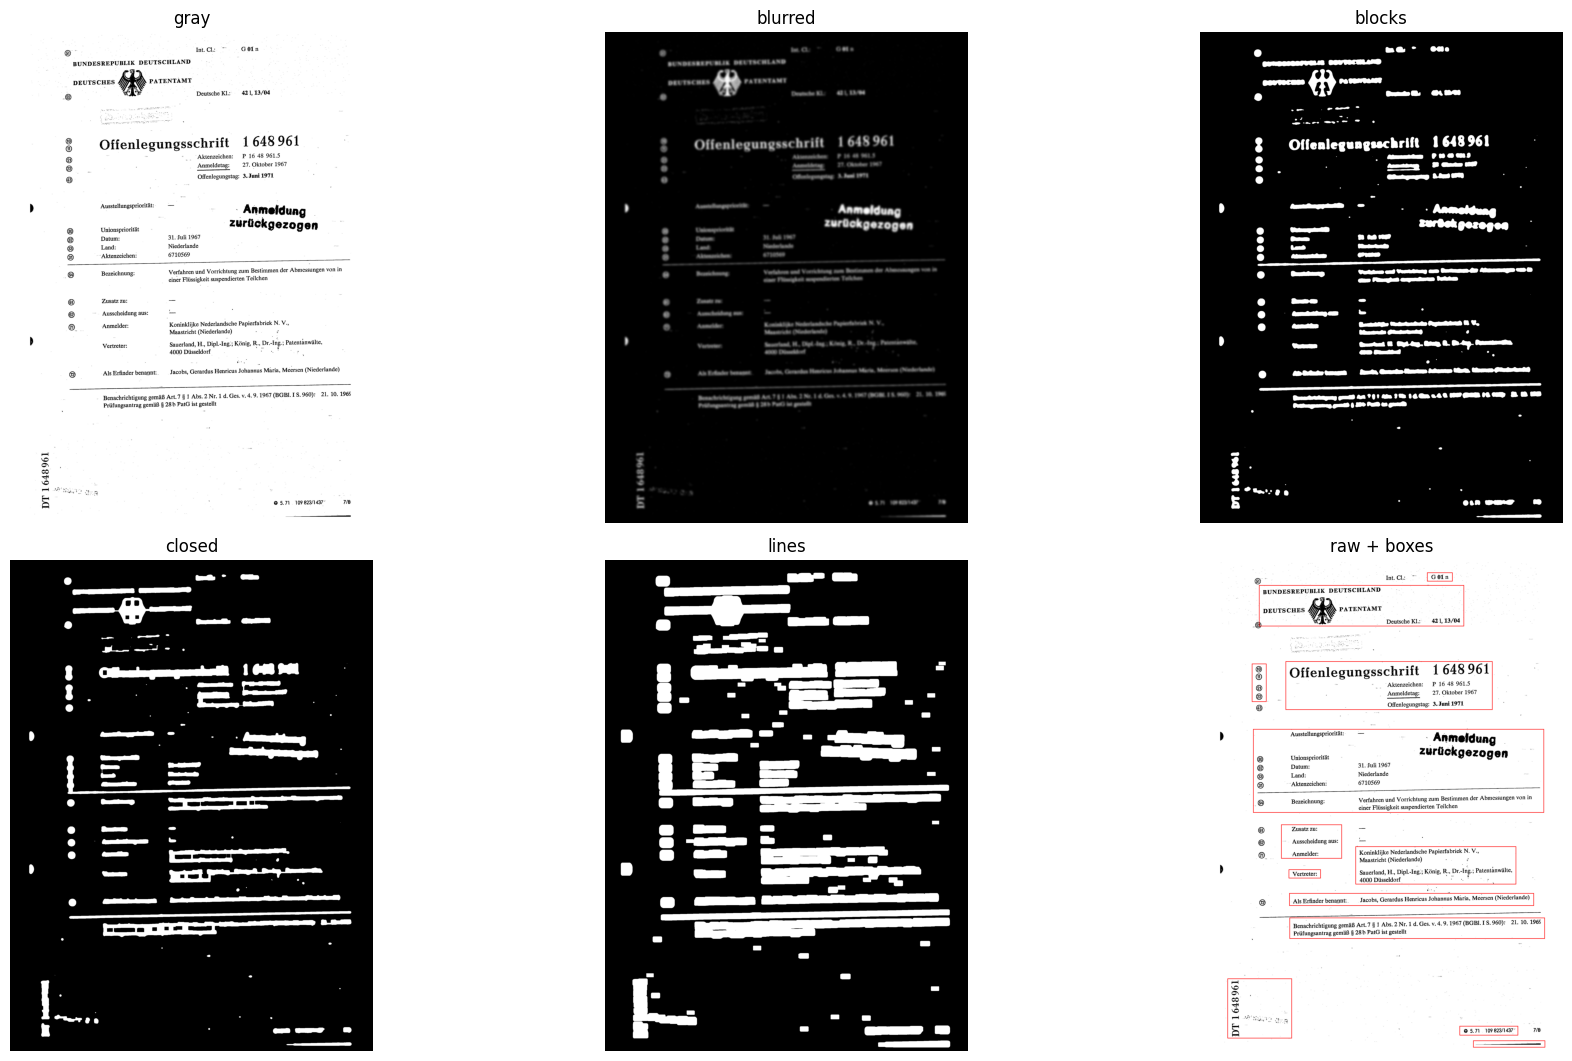

In [8]:
def segment_document_v5(pil_img):
    import cv2
    import numpy as np

    gray = np.array(pil_img.convert("L"))

    # 1. léger clean
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)

    # 2. inversion
    inv = 255 - gray_blur

    # 3. BIG blur (fusion top + titre)
    blurred = cv2.GaussianBlur(inv, (41,41), 0)

    # 4. threshold adaptatif propre
    blocks = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        101, -10
    )

    # 5. closing léger pour lisser
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
    closed = cv2.morphologyEx(blocks, cv2.MORPH_CLOSE, kernel)

    # 5.5 kernel line horizontales
    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (50,25))
    fused = cv2.dilate(closed, kernel_line, iterations=1)
    # 6. contours
    contours, _ = cv2.findContours(fused, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    H,W = gray.shape
    boxes = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if w*h < 3000: continue
        boxes.append([x,y,x+w,y+h])

    # 7. remove nested boxes
    iou_thresh = 0.7
    nested_cleaned = []
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        areaA = (x2-x1)*(y2-y1)

        keep = True
        for j, (X1, Y1, X2, Y2) in enumerate(boxes):
            if i == j:
                continue
            areaB = (X2-X1)*(Y2-Y1)

            # Intersection
            ix1 = max(x1, X1)
            iy1 = max(y1, Y1)
            ix2 = min(x2, X2)
            iy2 = min(y2, Y2)
            inter = max(0, ix2 - ix1) * max(0, iy2 - iy1)

            # si 70% de la petite box est dans une grande → c’est un trou inutile
            if inter / areaA > iou_thresh and areaA < areaB:
                keep = False
                break

        if keep:
            nested_cleaned.append([x1, y1, x2, y2])

    final = []
    for (x1, y1, x2, y2) in nested_cleaned:
        w = x2 - x1
        h = y2 - y1

        # Taille minimale
        if w > 100 and h > 100:
            final.append([x1, y1, x2, y2])
            continue

        crop = blocks[y1:y2, x1:x2]

        total = crop.size
        fg = np.sum(crop == 255)
        ratio = fg / total if total > 0 else 0

        # trop vide = poubelle
        if ratio < 0.3:
            continue

        final.append([x1, y1, x2, y2])

    # 8. tri final
    merged = True
    boxes2 = final.copy()

    while merged:
        merged = False
        new = []
        used = set()

        for i in range(len(boxes2)):
            if i in used:
                continue

            x1,y1,x2,y2 = boxes2[i]
            mbox = [x1,y1,x2,y2]

            for j in range(i+1, len(boxes2)):
                if j in used:
                    continue

                X1,Y1,X2,Y2 = boxes2[j]

                # "proches" (gap réglable)
                close_h = abs(y1 - Y1) < 30 or abs(y2 - Y2) < 30
                touching_h = not (x2 < X1 - 60 or X2 < x1 - 60)

                close_v = abs(x1 - X1) < 60 or abs(x2 - X2) < 60
                touching_v = not (y2 < Y1 - 30 or Y2 < y1 - 30)

                if (close_h and touching_h) or (close_v and touching_v):
                    mbox = [
                        min(mbox[0], X1),
                        min(mbox[1], Y1),
                        max(mbox[2], X2),
                        max(mbox[3], Y2)
                    ]
                    used.add(j)
                    merged = True

                # Corner overlap
                corner_overlap = (
                    (X1 <= x1 <= X2 and Y1 <= y1 <= Y2) or
                    (X1 <= x1 <= X2 and Y1 <= y2 <= Y2) or
                    (x1 <= X1 <= x2 and y1 <= Y1 <= y2) or
                    (x1 <= X1 <= x2 and y1 <= Y2 <= y2)
                )

                if corner_overlap:
                    mbox = [
                        min(mbox[0], X1),
                        min(mbox[1], Y1),
                        max(mbox[2], X2),
                        max(mbox[3], Y2)
                    ]
                    used.add(j)
                    merged = True
                    continue

            used.add(i)
            new.append(mbox)

        boxes2 = new

    final = boxes2
    final.sort(key=lambda b: (b[1], b[0]))

    # 9. retour pour debug
    out = {
        "gray":gray,
        "blurred":blurred,
        "blocks":blocks,
        "closed":closed,
        "lines":fused
    }

    return out, final


from pdf2image import convert_from_path
import matplotlib.pyplot as plt

def show_debug_with_boxes(raw_img, out, boxes):
    """
    Affiche toutes les étapes du pipeline + l'image brute annotée.
    raw_img : PIL.Image
    out     : dict d'étapes intermédiaires
    boxes   : liste de [x1,y1,x2,y2]
    """

    steps = out.keys()

    nb_steps = len(steps)

    plt.figure(figsize=(18, 16))

    # --- 1. Étapes intermédiaires ---
    for i, k in enumerate(steps):
        plt.subplot(3, 3, i+1)
        plt.title(k)
        plt.imshow(out[k], cmap="gray")
        plt.axis("off")

    # --- 2. RAW + boxes ---
    plt.subplot(3, 3, nb_steps+1)
    plt.title("raw + boxes")

    raw_np = np.array(raw_img).copy()
    vis = raw_np.copy()

    # Dessine les rectangles (rouge)
    for (x1, y1, x2, y2) in boxes:
        vis[y1:y1+4, x1:x2] = [255, 0, 0]   # top
        vis[y2-4:y2, x1:x2] = [255, 0, 0]   # bottom
        vis[y1:y2, x1:x1+4] = [255, 0, 0]   # left
        vis[y1:y2, x2-4:x2] = [255, 0, 0]   # right

    plt.imshow(vis)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Exemple avec un de tes fichiers
doc = "data/gold_standard_DE/PNGs_extracted/DE-1639221-A1.pdf"
images= convert_from_path(doc, dpi=300, first_page=1, last_page=1)
img = images[0]
doc = "data/gold_standard_DE/PNGs_extracted/DE-1648961-A1.png"
img = Image.open(doc).convert("RGB")

out, boxes = segment_document_v5(img)
show_debug_with_boxes(img, out, boxes)


📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-202887-C.png
➡️  5 boxes detected


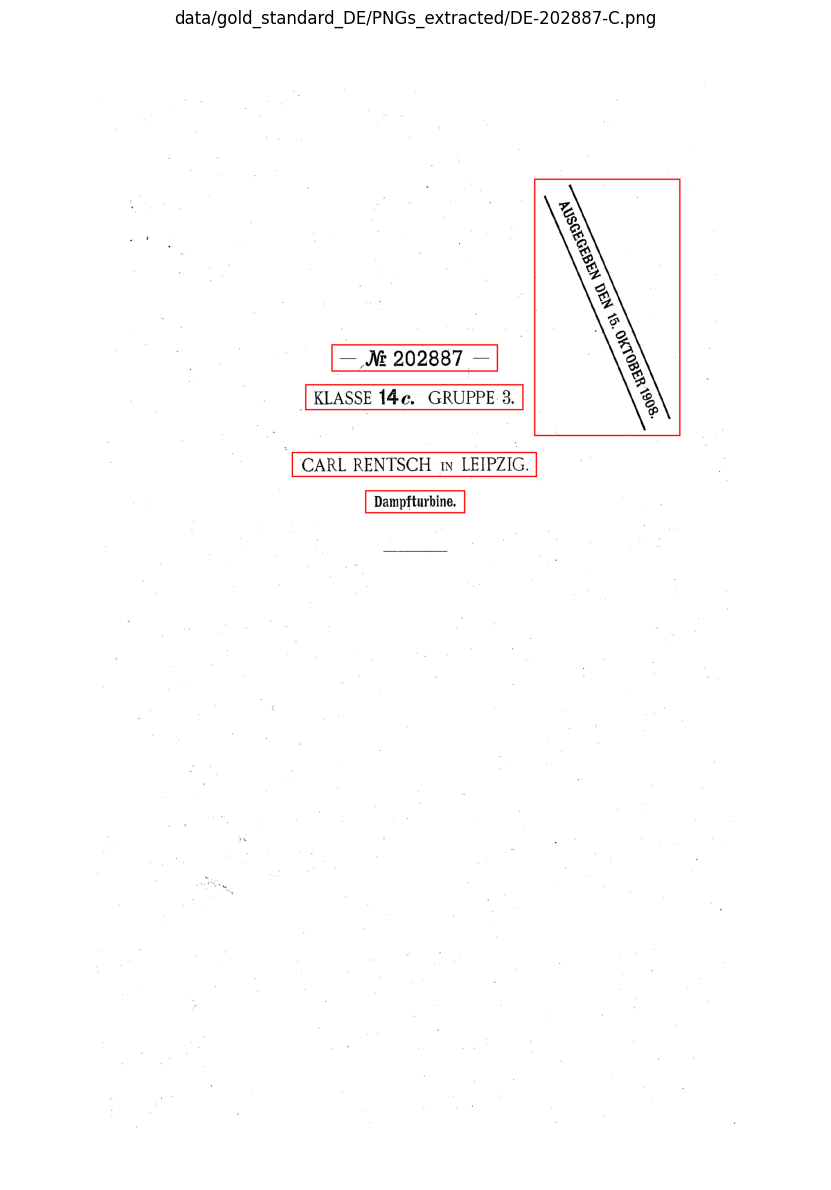

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-6546-C.png
➡️  9 boxes detected


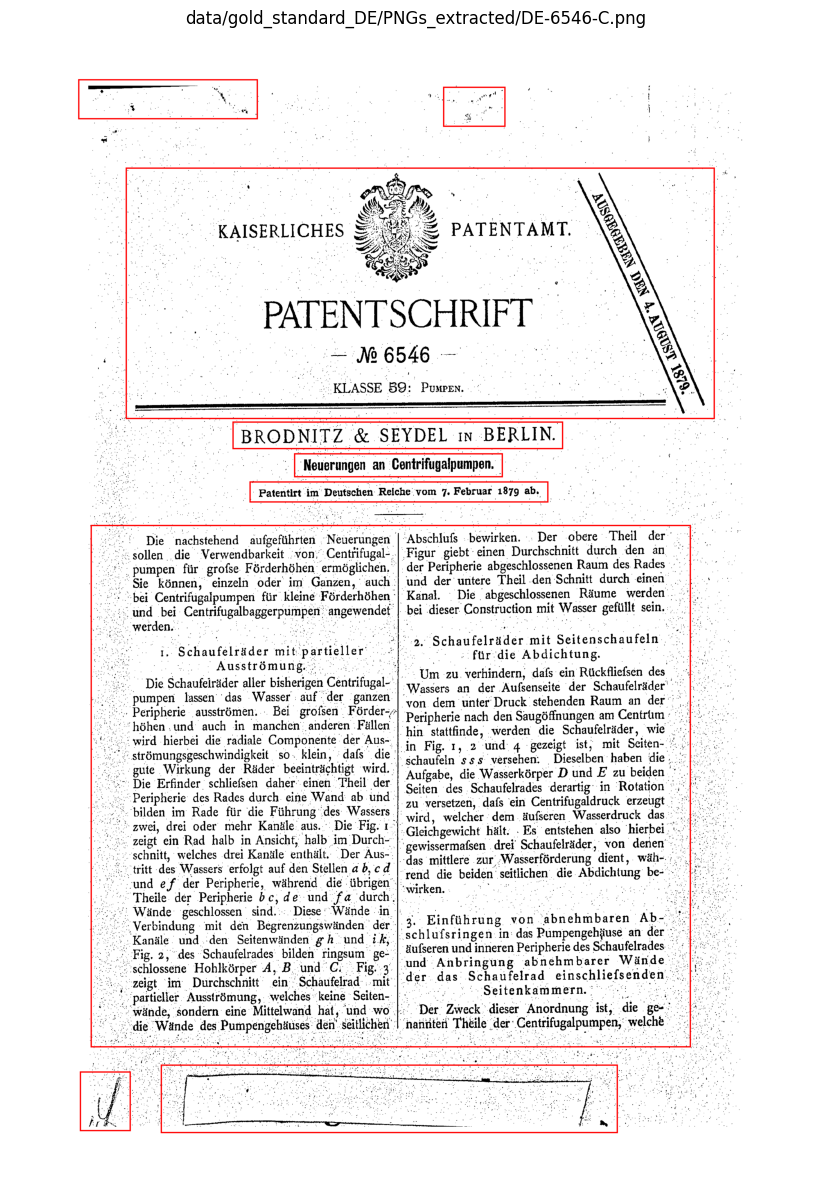

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-13224-C.png
➡️  11 boxes detected


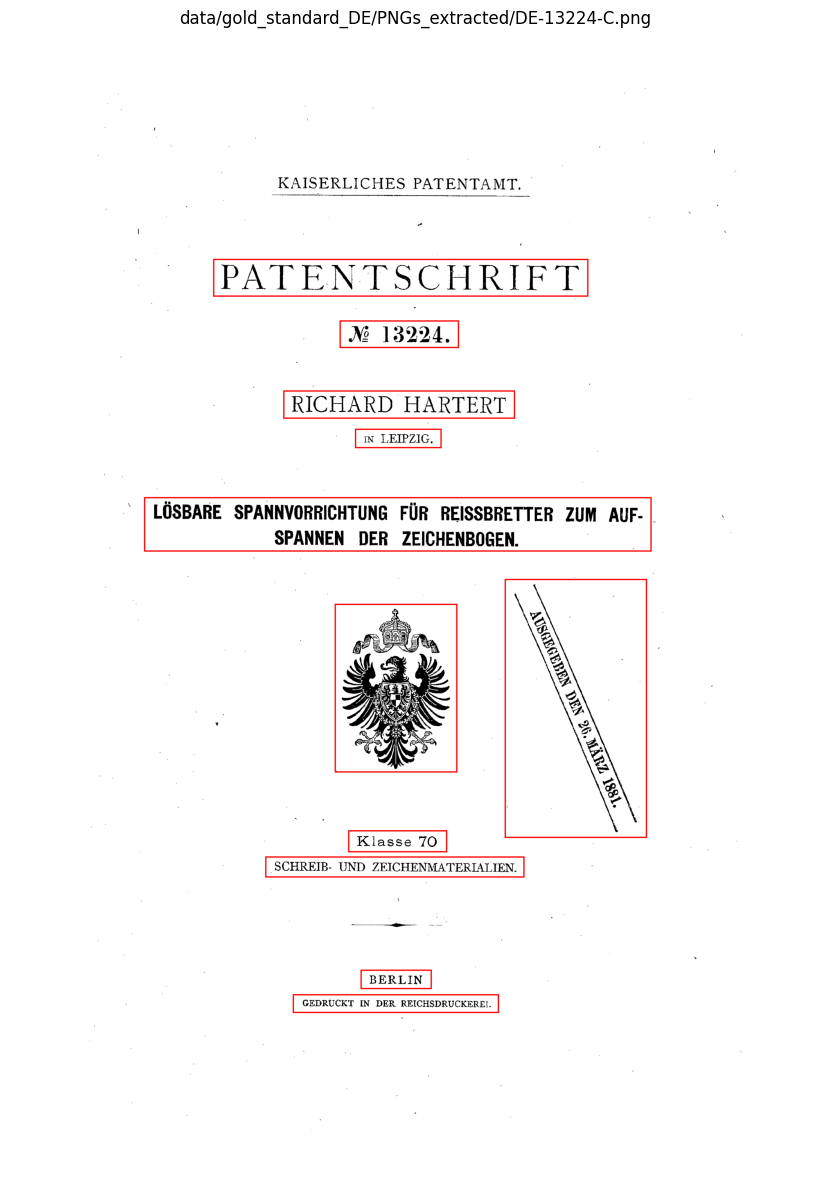

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png
➡️  8 boxes detected


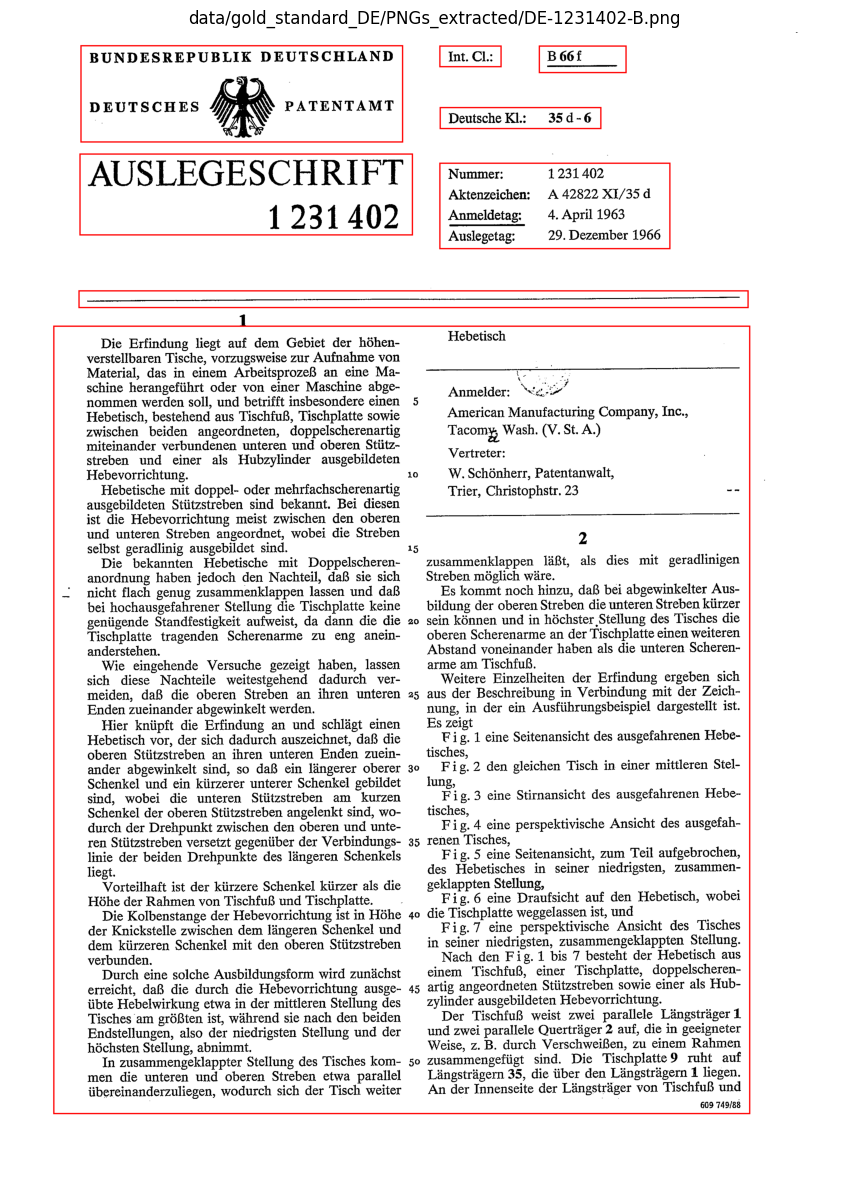

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-1271093-C2.png
➡️  14 boxes detected


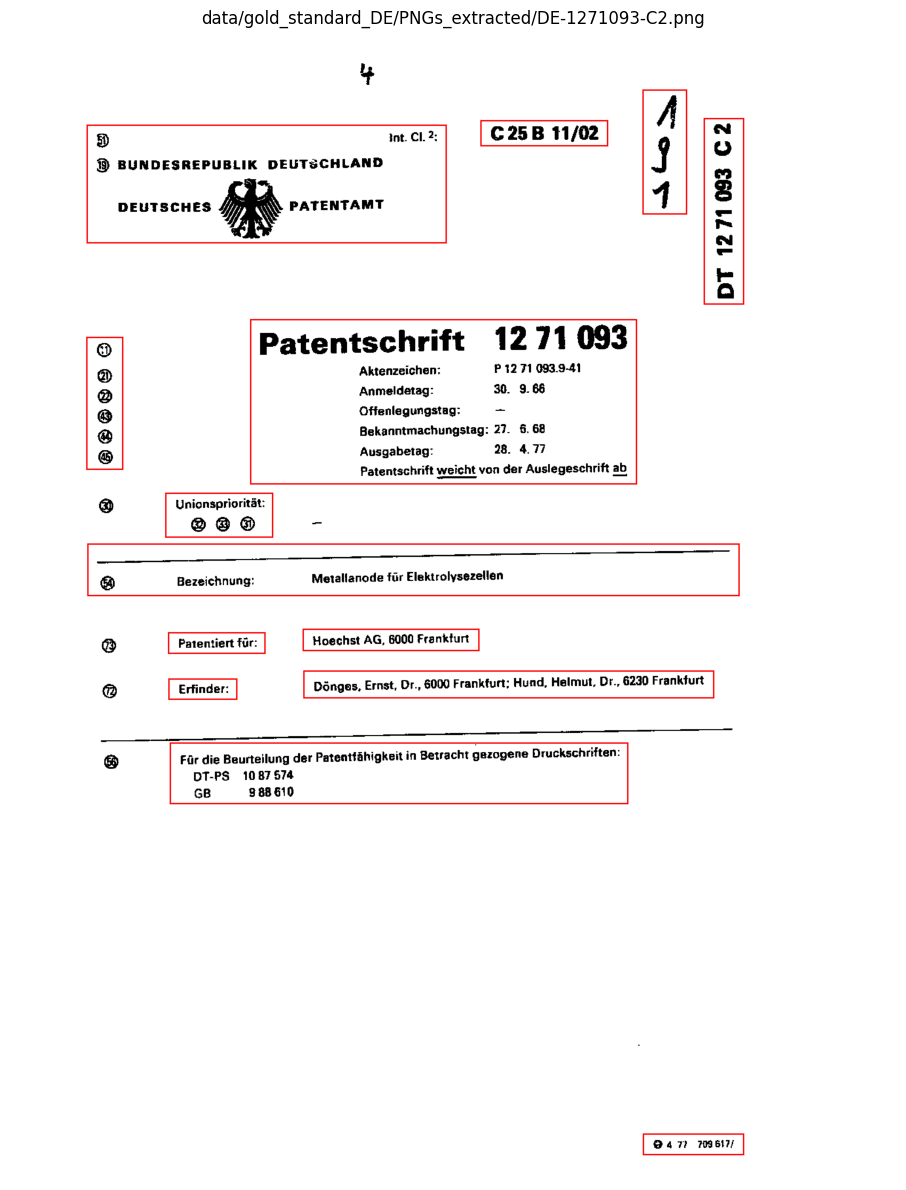

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-953673-C.png
➡️  14 boxes detected


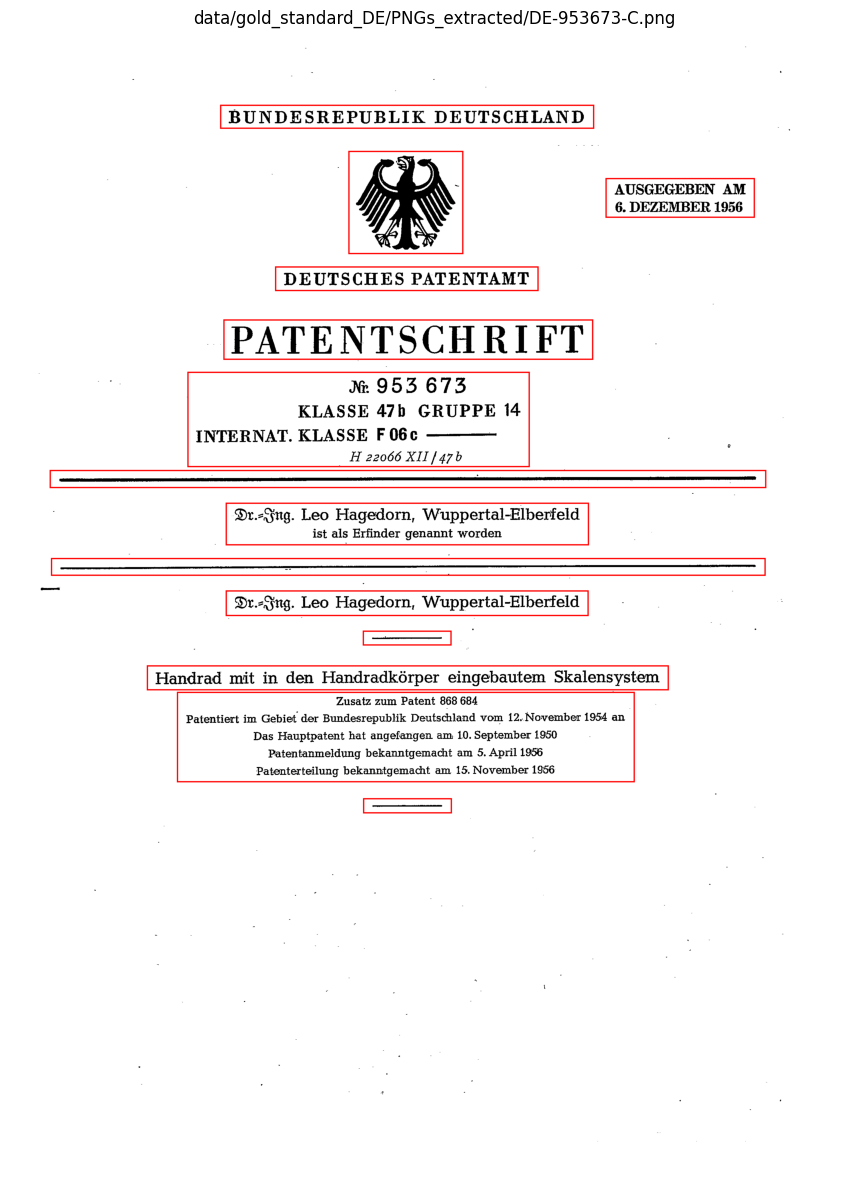

📄 Testing: data/gold_standard_DE/PNGs_extracted/DE-1545252-A1.pdf
➡️  18 boxes detected


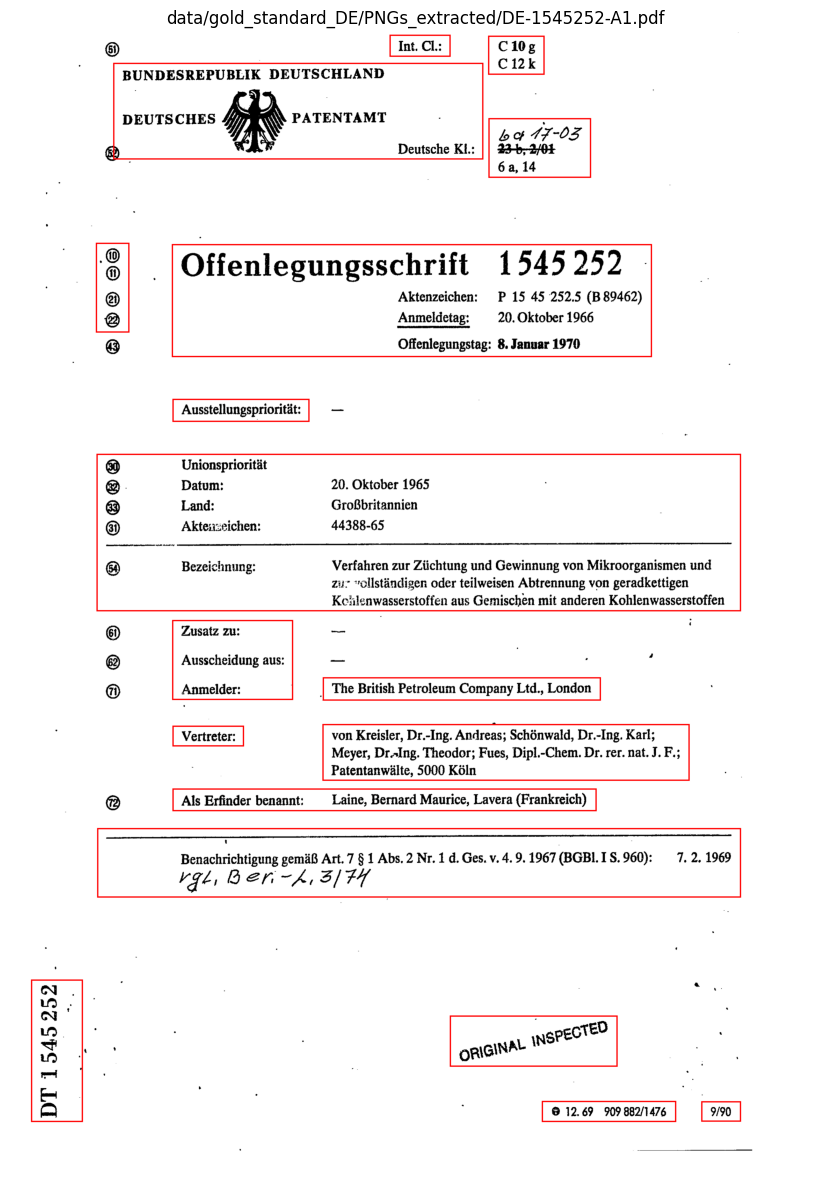

In [9]:
import fitz
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Liste de documents
# -------------------------------------------------------------
doc_paths = [
    "data/gold_standard_DE/PNGs_extracted/DE-202887-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-6546-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-13224-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1271093-C2.png",
    "data/gold_standard_DE/PNGs_extracted/DE-953673-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1545252-A1.pdf"
]


# -------------------------------------------------------------
# Fonction de visualisation
# -------------------------------------------------------------
def visualize_segmentations(doc_paths, segment_fn):
    for doc_path in doc_paths:

        print("📄 Testing:", doc_path)
        doc = Path(doc_path)

        # --- Charge l’image ou PDF
        if doc.suffix.lower() == ".pdf":
            pdf = fitz.open(str(doc))
            page = pdf.load_page(0)
            pix = page.get_pixmap(dpi=300)
            raw_img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
        else:
            raw_img = Image.open(doc).convert("RGB")

        # --- Segmentation
        out, boxes = segment_fn(raw_img)

        print(f"➡️  {len(boxes)} boxes detected")

        # --- Visualisation NumPy
        raw_np = np.array(raw_img).copy()
        vis = raw_np.copy()

        for (x1, y1, x2, y2) in boxes:
            vis[y1:y1+4, x1:x2] = [255, 0, 0]   # top
            vis[y2-4:y2, x1:x2] = [255, 0, 0]   # bottom
            vis[y1:y2, x1:x1+4] = [255, 0, 0]   # left
            vis[y1:y2, x2-4:x2] = [255, 0, 0]   # right

        # --- Plot
        plt.figure(figsize=(10, 12))
        plt.imshow(vis)
        plt.axis("off")
        plt.title(doc_path)
        plt.tight_layout()
        plt.show()


# -------------------------------------------------------------
# Lance la visualisation
# -------------------------------------------------------------
visualize_segmentations(doc_paths, segment_document_v5)


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import pytesseract
from pathlib import Path

def merge_boxes_smart(boxes, min_v_overlap=0.15, max_h_gap=180):
    """
    Fusionne les boîtes si elles semblent appartenir au même bloc logique :
    - suffisamment de recouvrement vertical
    - distance horizontale raisonnable
    """
    merged = True
    boxes2 = boxes.copy()

    while merged:
        merged = False
        new = []
        used = set()

        for i in range(len(boxes2)):
            if i in used:
                continue

            x1,y1,x2,y2 = boxes2[i]
            mbox = [x1,y1,x2,y2]

            for j in range(i+1, len(boxes2)):
                if j in used:
                    continue

                X1,Y1,X2,Y2 = boxes2[j]

                # --- overlap vertical (en % de la plus petite hauteur)
                inter_v = max(0, min(y2, Y2) - max(y1, Y1))
                min_h = min((y2-y1), (Y2-Y1))
                v_ok = (inter_v / min_h) > min_v_overlap

                # --- distance horizontale
                gap_h = min(abs(x1 - X2), abs(X1 - x2))
                h_ok = gap_h < max_h_gap

                if v_ok and h_ok:
                    # Fusion
                    mbox = [
                        min(mbox[0], X1),
                        min(mbox[1], Y1),
                        max(mbox[2], X2),
                        max(mbox[3], Y2)
                    ]
                    used.add(j)
                    merged = True

            used.add(i)
            new.append(mbox)

        boxes2 = new

    return boxes2

def cluster_boxes_horizontally(boxes, tolerance_y=30):
    """
    Regroupe seulement en bandes horizontales.
    Ne split PAS les boîtes.
    Ne merge PAS.
    Sert uniquement à trier dans l’ordre de lecture (haut→bas, gauche→droite).
    """
    if not boxes:
        return []

    # 1) calcul centre Y
    boxes_with_cy = []
    for b in boxes:
        x1,y1,x2,y2 = b
        cy = (y1+y2)/2
        boxes_with_cy.append((b, cy))

    boxes_with_cy.sort(key=lambda x: x[1])

    # 2) bandes horizontales
    bands = []
    current = [boxes_with_cy[0][0]]
    last_cy = boxes_with_cy[0][1]

    for b, cy in boxes_with_cy[1:]:
        if abs(cy - last_cy) <= tolerance_y:
            current.append(b)
        else:
            bands.append(current)
            current = [b]
        last_cy = cy

    bands.append(current)

    # 3) tri interne dans chaque bande (gauche→droite)
    sorted_final = []
    for band in bands:
        band_sorted = sorted(band, key=lambda b: b[0])
        sorted_final.extend(band_sorted)

    return sorted_final
def merge_boxes_brutal(boxes, overlap_thresh=0.15):
    """
    Fusionne N'IMPORTE QUELLES boxes qui se chevauchent
    ou se touchent légèrement (robuste pour les docs bruités).
    """
    merged = True

    while merged:
        merged = False
        new = []
        used = set()

        for i in range(len(boxes)):
            if i in used:
                continue

            x1,y1,x2,y2 = boxes[i]
            B = [x1,y1,x2,y2]

            for j in range(i+1, len(boxes)):
                if j in used:
                    continue

                X1,Y1,X2,Y2 = boxes[j]

                # zones
                inter_w = max(0, min(x2, X2) - max(x1, X1))
                inter_h = max(0, min(y2, Y2) - max(y1, Y1))
                inter = inter_w * inter_h
                areaA = (x2-x1)*(y2-y1)
                areaB = (X2-X1)*(Y2-Y1)

                # chevauchement > 15%
                if inter > 0 and (
                    inter/areaA > overlap_thresh or
                    inter/areaB > overlap_thresh
                ):
                    B = [
                        min(B[0], X1),
                        min(B[1], Y1),
                        max(B[2], X2),
                        max(B[3], Y2)
                    ]
                    used.add(j)
                    merged = True

                # touches horizontalement
                if abs(y1 - Y2) < 20 or abs(y2 - Y1) < 20:
                    B = [
                        min(B[0], X1),
                        min(B[1], Y1),
                        max(B[2], X2),
                        max(B[3], Y2)
                    ]
                    used.add(j)
                    merged = True

                # # touches verticalement
                # if abs(x1 - X2) < 20 or abs(x2 - X1) < 20:
                #     B = [
                #         min(B[0], X1),
                #         min(B[1], Y1),
                #         max(B[2], X2),
                #         max(B[3], Y2)
                #     ]
                #     used.add(j)
                #     merged = True

            used.add(i)
            new.append(B)

        boxes = new

    return boxes

def needs_fallback(final, H, W, area_ratio=0.50):
    if len(final) == 1:
        x1,y1,x2,y2 = final[0]
        area = (x2-x1)*(y2-y1)
        if area / (H*W) > area_ratio:
            return True
    return False
def refine_big_block(pil_img, block,
                     title_ratio=0.22,
                     valley_rel_thresh=0.55):
    """
    Fallback quand on a une seule énorme box.
    - Coupe en haut un bandeau de hauteur = title_ratio du bloc (titre/logo).
    - Sur le reste, détecte 1 ou 2 colonnes via projection verticale.
    Retourne 2 ou 3 boxes.
    """

    x1, y1, x2, y2 = block
    crop = np.array(pil_img.crop((x1, y1, x2, y2)).convert("L"))
    H, W = crop.shape

    # 1) Titre = bandeau haut fixe (22 % du bloc par défaut)
    title_h = max(60, int(H * title_ratio))
    title_h = min(title_h, H - 60)  # sécurité
    title_box = [x1, y1, x2, y1 + title_h]

    # 2) Corps de texte (le reste)
    body = crop[title_h:, :]
    body_y0 = y1 + title_h
    Hb, Wb = body.shape

    # 3) Projection verticale pour voir s'il y a 1 ou 2 colonnes
    vproj = np.sum(body < 200, axis=0)

    # on ignore les 10% de bords gauche/droite (bruit)
    margin = max(5, int(0.10 * Wb))
    inner = vproj[margin:Wb - margin]
    if inner.size == 0:
        # fallback : tout en une colonne
        return [title_box, [x1, body_y0, x2, y2]]

    max_val = inner.max()
    min_idx = inner.argmin() + margin
    min_val = inner[min_idx - margin]

    # profondeur de la vallée au centre
    has_two_cols = (max_val > 0) and (min_val / max_val < valley_rel_thresh)

    boxes = [title_box]

    if has_two_cols:
        # split à la vallée centrale
        split_x = min_idx
        # colonne gauche
        boxes.append([x1,          body_y0, x1 + split_x, y2])
        # colonne droite
        boxes.append([x1 + split_x, body_y0, x2,          y2])
    else:
        # une seule grosse colonne
        boxes.append([x1, body_y0, x2, y2])

    return boxes


def segment_document_v5(pil_img):


    gray = np.array(pil_img.convert("L"))

    # 1. léger clean
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)

    # 2. inversion
    inv = 255 - gray_blur

    # 3. BIG blur (fusion top + titre)
    blurred = cv2.GaussianBlur(inv, (41,41), 0)

    # 4. threshold adaptatif propre
    blocks = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        101, -10
    )

    # 5. closing léger pour lisser
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
    closed = cv2.morphologyEx(blocks, cv2.MORPH_CLOSE, kernel)

    # 5.5 kernel line horizontales
    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (50,25))
    fused = cv2.dilate(closed, kernel_line, iterations=1)
    # 6. contours
    contours, _ = cv2.findContours(fused, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    H,W = gray.shape
    boxes = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if w*h < 3000: continue
        boxes.append([x,y,x+w,y+h])

    # 7. remove nested boxes
    iou_thresh = 0.7
    nested_cleaned = []
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        areaA = (x2-x1)*(y2-y1)

        keep = True
        for j, (X1, Y1, X2, Y2) in enumerate(boxes):
            if i == j:
                continue
            areaB = (X2-X1)*(Y2-Y1)

            # Intersection
            ix1 = max(x1, X1)
            iy1 = max(y1, Y1)
            ix2 = min(x2, X2)
            iy2 = min(y2, Y2)
            inter = max(0, ix2 - ix1) * max(0, iy2 - iy1)

            # si 70% de la petite box est dans une grande → c’est un trou inutile
            if inter / areaA > iou_thresh and areaA < areaB:
                keep = False
                break

        if keep:
            nested_cleaned.append([x1, y1, x2, y2])

    final = []
    for (x1, y1, x2, y2) in nested_cleaned:
        w = x2 - x1
        h = y2 - y1

        # Taille minimale
        if w > 100 and h > 100:
            final.append([x1, y1, x2, y2])
            continue

        crop = blocks[y1:y2, x1:x2]

        total = crop.size
        fg = np.sum(crop == 255)
        ratio = fg / total if total > 0 else 0

        # trop vide = poubelle
        if ratio < 0.3:
            continue

        final.append([x1, y1, x2, y2])

    # 8. tri final
    # boxes2 = merge_boxes_smart(final, min_v_overlap=0.15, max_h_gap=180)
    boxes2 = merge_boxes_brutal(final)
    final = cluster_boxes_horizontally(boxes2)

    if needs_fallback(final, H, W):
        final = refine_big_block(pil_img, final[0])
    # 9. retour pour debug
    out = {
        "gray":gray,
        "blurred":blurred,
        "blocks":blocks,
        "closed":closed,
        "lines":fused
    }

    return out, final

def deskew_image(pil_img, max_angle: float = 15.0):
    gray = np.array(pil_img.convert("L"))
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bw = cv2.bitwise_not(bw)

    coords = np.column_stack(np.where(bw > 0))
    if coords.size == 0:
        return pil_img

    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    angle = -(90 + angle) if angle < -45 else -angle

    if abs(angle) < 0.1 or abs(angle) > max_angle:
        return pil_img

    # rotation sur l’original en RGB pour éviter les surprises dtype
    img_cv = np.array(pil_img.convert("RGB"))  # <-- convert en RGB
    (h, w) = img_cv.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(img_cv, M, (w, h),
                             flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return Image.fromarray(rotated)
def deskew_fast(pil_img, max_angle=15.0):
    img = np.array(pil_img.convert("L"))
    edges = cv2.Canny(img, 50, 150)

    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=160)
    if lines is None:
        return pil_img

    angles = []
    for l in lines:
        rho, theta = l[0]
        angle_deg = (theta - np.pi/2) * 180.0 / np.pi

        if -45 < angle_deg < 45:
            angles.append(angle_deg)

    if not angles:
        return pil_img

    median_angle = float(np.median(angles))
    if abs(median_angle) < 0.1 or abs(median_angle) > max_angle:
        return pil_img

    h, w = img.shape
    M = cv2.getRotationMatrix2D((w//2, h//2), median_angle, 1.0)

    img_cv = np.array(pil_img.convert("RGB"))
    rotated = cv2.warpAffine(np.array(img_cv), M, (w, h),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
    return Image.fromarray(rotated)

def smart_deskew(pil_img,
                 hough_max_angle=15.0,
                 proj_max_angle=2.0,
                 proj_delta=0.1):
    """
    Deskew unique et robuste :
    1) essai rapide via HoughLines
    2) fallback vers projection horizontale si Hough échoue
    Retourne directement une PIL.Image deskewée.
    """

    # Convert to grayscale
    img_gray = np.array(pil_img.convert("L"))

    # -------------------------
    # 1) Tentative rapide (HoughLines)
    # -------------------------
    edges = cv2.Canny(img_gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=160)

    angle_fast = 0.0
    if lines is not None:
        angles = []
        for l in lines:
            rho, theta = l[0]
            angle_deg = (theta - np.pi/2) * 180.0 / np.pi
            if -45 < angle_deg < 45:
                angles.append(angle_deg)

        if angles:
            median_angle = float(np.median(angles))
            # On accepte un deskew rapide si angle significatif
            if 0.3 < abs(median_angle) < hough_max_angle:
                angle_fast = median_angle

    # Si Hough a trouvé un vrai angle → appliquer directement
    if abs(angle_fast) >= 0.3:
        h, w = img_gray.shape
        M = cv2.getRotationMatrix2D((w//2, h//2), angle_fast, 1.0)
        img_rgb = np.array(pil_img.convert("RGB"))
        rotated = cv2.warpAffine(img_rgb, M, (w, h),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REPLICATE)
        return Image.fromarray(rotated)

    # -------------------------
    # 2) Fallback : Deskew par projection
    # -------------------------
    img = img_gray.copy()
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    best_var = -1
    best_angle = 0
    angles = np.arange(-proj_max_angle, proj_max_angle + proj_delta, proj_delta)

    for angle in angles:
        M = cv2.getRotationMatrix2D((bw.shape[1]//2, bw.shape[0]//2), angle, 1.0)
        rotated_bw = cv2.warpAffine(bw, M, (bw.shape[1], bw.shape[0]),
                                    flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_REPLICATE)

        # projection horizontale
        proj = np.sum(rotated_bw == 0, axis=1)
        var = np.var(proj)

        if var > best_var:
            best_var = var
            best_angle = angle

    # Appliquer l'angle optimal
    M = cv2.getRotationMatrix2D((pil_img.width//2, pil_img.height//2),
                                best_angle, 1.0)
    img_rgb = np.array(pil_img.convert("RGB"))
    rotated = cv2.warpAffine(img_rgb, M,
                             (pil_img.width, pil_img.height),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)

    return Image.fromarray(rotated)

def autocrop_image(pil_img, threshold=245):
    """
    Supprime les marges quasi-blanches autour du texte.
    threshold : 0-255 au-dessus duquel on considère la zone blanche.
    """
    np_img = np.array(pil_img.convert("L"))
    mask = np_img < threshold
    coords = np.argwhere(mask)
    if coords.size == 0:
        return pil_img
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1  # slices non inclusives
    cropped = pil_img.crop((x0, y0, x1, y1))
    return cropped
def clahe(gray, clip=2.0, grid=8):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(grid, grid))
    return clahe.apply(gray)
def otsu_threshold(gray):
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return bw
def sauvola_threshold(gray, window=25, k=0.2):
    thresh_sauvola = filters.threshold_sauvola(gray, window_size=window, k=k)
    binary = gray > thresh_sauvola
    return img_as_ubyte(binary)
def niblack_threshold(gray, window=25, k=0.8):
    thresh = filters.threshold_niblack(gray, window_size=window, k=k)
    binary = gray > thresh
    return img_as_ubyte(binary)
def preprocess_image(pil_img, method="otsu"):
    # 0) upscale plus fort pour stabiliser les accents
    up = pil_img.resize(
        (int(pil_img.width * 2.0), int(pil_img.height * 2.0)),
        Image.LANCZOS
    )
    # 2) CLAHE doux
    gray = np.array(up.convert("L"))
    gray = clahe(gray, clip=1.2, grid=8)

    # 3) Binarisation
    if method == "otsu":
        bw = otsu_threshold(gray)
    elif method == "sauvola":
        bw = sauvola_threshold(gray, window=25, k=0.3)
    elif method == "niblack":
        bw = niblack_threshold(gray, window=25, k=0.8)
    else:
        raise ValueError("Unknown preprocess method")

    # Optional: petit medianBlur
    bw = cv2.medianBlur(bw, 3)

    pil_out = Image.fromarray(bw)
    pil_out = ImageOps.autocontrast(pil_out)
    pil_out = autocrop_image(pil_out, threshold=245)

    return pil_out
def preprocess_image_light(pil_img):
    gray = np.array(pil_img.convert("L"))

    # 1) léger débruitage
    gray = cv2.GaussianBlur(gray, (1,1), 0)

    # 2) CLAHE doux
    gray = clahe(gray, clip=1.2, grid=32)
    return Image.fromarray(gray)


def ocr_one_document(pil_img, lang="deu"):
    """
    Pipeline complet :
    - segmentation (ton segment_document_v5 actuel)
    - preprocess OCR sur chaque bloc
    - OCR (psm=6)
    - reconstruction texte en ordre logique
    """

    # --- segmentation ---
    # pil_img = deskew_image(pil_img, max_angle=10.0)
    pil_img = deskew_fast(pil_img)
    _, boxes = segment_document_v5(pil_img)
    print(boxes)
    results = []

    for i,(x1, y1, x2, y2) in enumerate(boxes):
        # 1. crop du bloc brut
        crop = pil_img.crop((x1, y1, x2, y2))
        # 2. préprocess OCR
        # crop_pre = preprocess_image(crop, method=preprocess_method)
        crop_pre = preprocess_image_light(crop)
        # crop_pre = crop
        # 3. OCR tesseract
        txt = pytesseract.image_to_string(
            crop_pre,
            lang=lang,
            config="--psm 3 --oem 1 -c preserve_interword_spaces=1"
        )

        results.append(txt.strip())

    # 4. recompose le tout proprement
    full_text = "\n\n".join(results)

    return full_text, results, boxes



doc_paths = [
    "data/gold_standard_DE/PNGs_extracted/DE-202887-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-6546-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-13224-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1271093-C2.png",
    "data/gold_standard_DE/PNGs_extracted/DE-953673-C.png",
    "data/gold_standard_DE/PNGs_extracted/DE-1545252-A1.pdf"
]
# doc = Image.open("data/gold_standard_DE/PNGs_extracted/DE-1231402-B.png")
# doc = "data/gold_standard_DE/PNGs_extracted/DE-1639221-A1.pdf"
# images= convert_from_path(doc, dpi=200, first_page=1, last_page=1)
# doc = images[0]
doc = Path("data/gold_standard_DE/PNGs_extracted/DE-1648961-A1.png")
doc = Image.open(doc).convert("RGB")
txt, parts, boxes = ocr_one_document(doc)
print(txt)


[[447, 102, 1909, 482], [386, 731, 2105, 1080], [384, 1207, 2459, 1810], [625, 1882, 862, 1948], [575, 1974, 2249, 2319], [625, 2397, 1063, 2463], [1104, 2397, 2373, 2464], [384, 2515, 2449, 2699], [171, 2973, 631, 3400], [1825, 3343, 2244, 3407], [1920, 3453, 2435, 3503]]
>:   :        Int. CL: ”  - G0In
BUNDESREPUBLIK DEUTSCHLAND          2

PATENTAMT

DEUTSCHES

)                                                                        Deutsche Kl.:  421,13/04

®®® ©®

Offenlegungsschrift   1 648 961

 "Aktenzeichen: P 16 48 961.5
. Anmeldetag:    27. Oktober 1967

Offenlegungstag: 3. Juni 1971

® |©88®

Ausstellungspriorität: -

Unionspriorität
Datum:
Land:

-- Aktenzeichen:

Bezeichnung:

31. Juli 1967
Niederlande
6710569

Verfahren und Vorrichtung zum Bestimmen der Abmessungen von in
einer Flüssigkeit suspendierten Teilchen

Zusatz zu:

Ausscheidung aus:             —

Anmelder:                      Koninklijke Nederlandsche Papierfabriek N. V.,
Maastricht (Niederlande)            

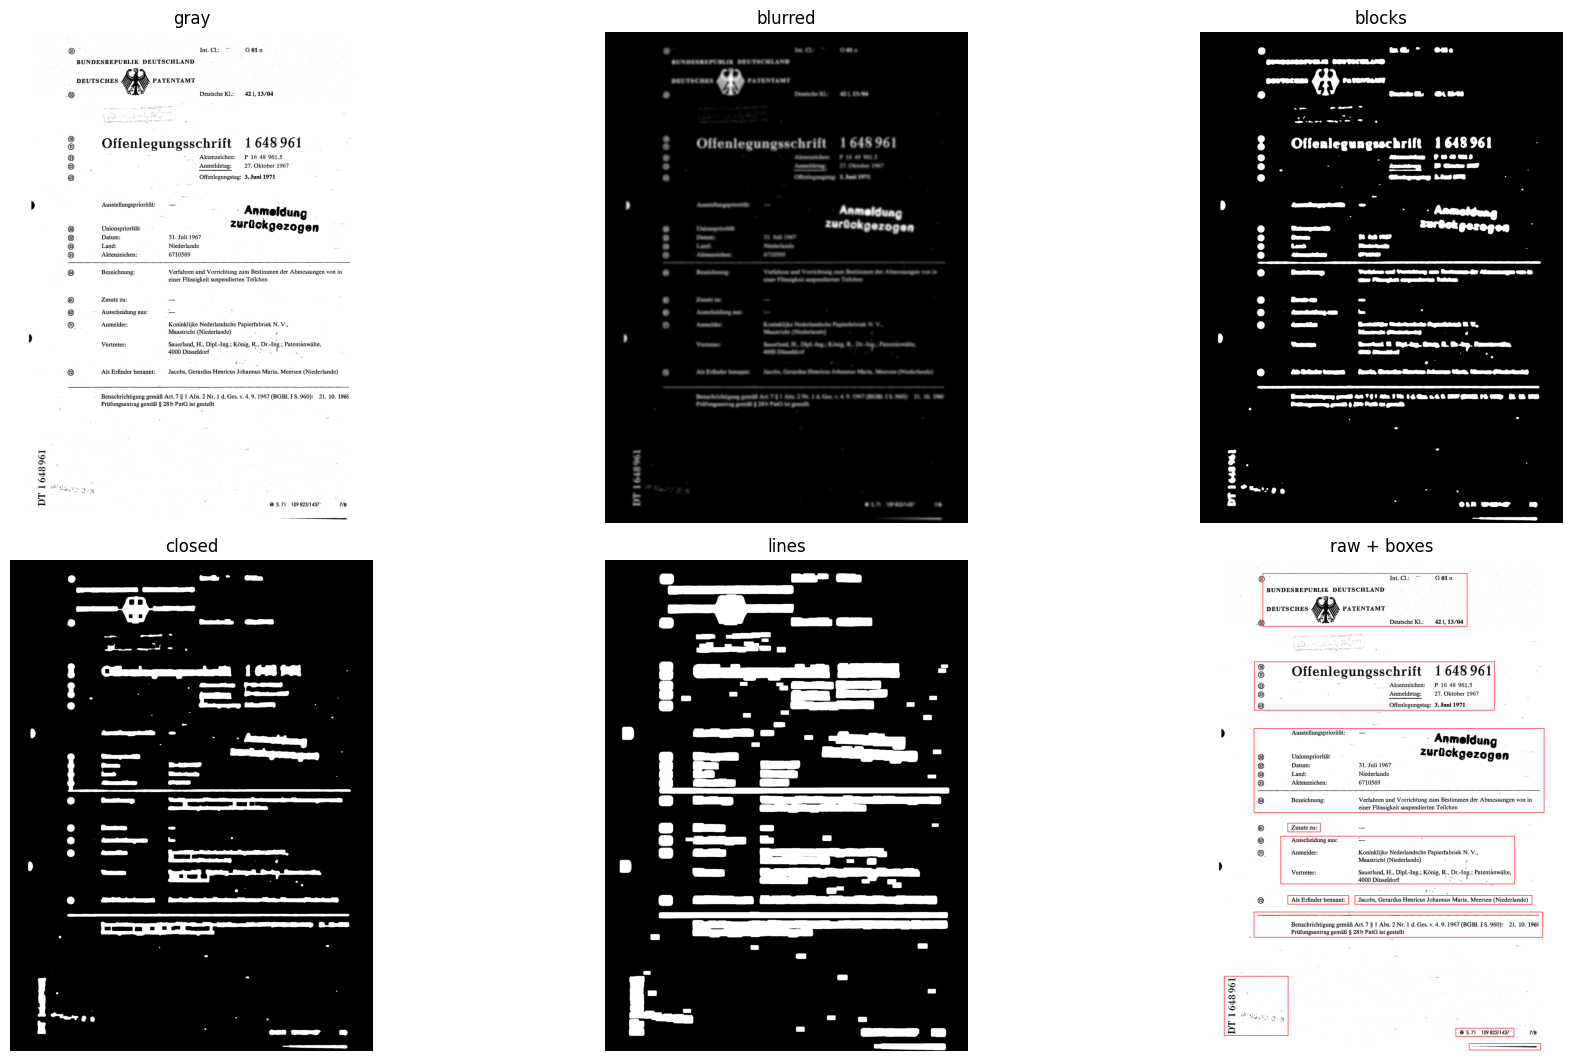

In [11]:

from pdf2image import convert_from_path
import matplotlib.pyplot as plt

def show_debug_with_boxes(raw_img, out, boxes):
    """
    Affiche toutes les étapes du pipeline + l'image brute annotée.
    raw_img : PIL.Image
    out     : dict d'étapes intermédiaires
    boxes   : liste de [x1,y1,x2,y2]
    """

    steps = out.keys()

    nb_steps = len(steps)

    plt.figure(figsize=(18, 16))

    # --- 1. Étapes intermédiaires ---
    for i, k in enumerate(steps):
        plt.subplot(3, 3, i+1)
        plt.title(k)
        plt.imshow(out[k], cmap="gray")
        plt.axis("off")

    # --- 2. RAW + boxes ---
    plt.subplot(3, 3, nb_steps+1)
    plt.title("raw + boxes")

    raw_np = np.array(raw_img).copy()
    vis = raw_np.copy()

    # Dessine les rectangles (rouge)
    for (x1, y1, x2, y2) in boxes:
        vis[y1:y1+4, x1:x2] = [255, 0, 0]   # top
        vis[y2-4:y2, x1:x2] = [255, 0, 0]   # bottom
        vis[y1:y2, x1:x1+4] = [255, 0, 0]   # left
        vis[y1:y2, x2-4:x2] = [255, 0, 0]   # right

    plt.imshow(vis)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Exemple avec un de tes fichiers
doc = "data/gold_standard_DE/PNGs_extracted/DE-1639221-A1.pdf"
images= convert_from_path(doc, dpi=300, first_page=1, last_page=1)
img = images[0]
doc = "data/gold_standard_DE/PNGs_extracted/DE-1648961-A1.png"
img = Image.open(doc).convert("RGB")

img_deskew = deskew_fast(img)

out, boxes = segment_document_v5(img_deskew)
show_debug_with_boxes(img_deskew, out, boxes)


Seed générée : 86857199
Total fichiers trouvés : 2158
Fichiers sélectionnés :
 - data/gold_standard_DE/PNGs_extracted/DE-606510-C.pdf
 - data/gold_standard_DE/PNGs_extracted/DE-2140209-A1.pdf
 - data/gold_standard_DE/PNGs_extracted/DE-1046676-B.png
 - data/gold_standard_DE/PNGs_extracted/DE-2325062-A1.png
 - data/gold_standard_DE/PNGs_extracted/DE-2059988-A1.pdf
 - data/gold_standard_DE/PNGs_extracted/DE-2509846-A1.pdf
Processing DE-606510-C.pdf...
Processing DE-2140209-A1.pdf...
Processing DE-1046676-B.png...
Fallback split triggered
Processing DE-2325062-A1.png...
Processing DE-2059988-A1.pdf...
Processing DE-2509846-A1.pdf...


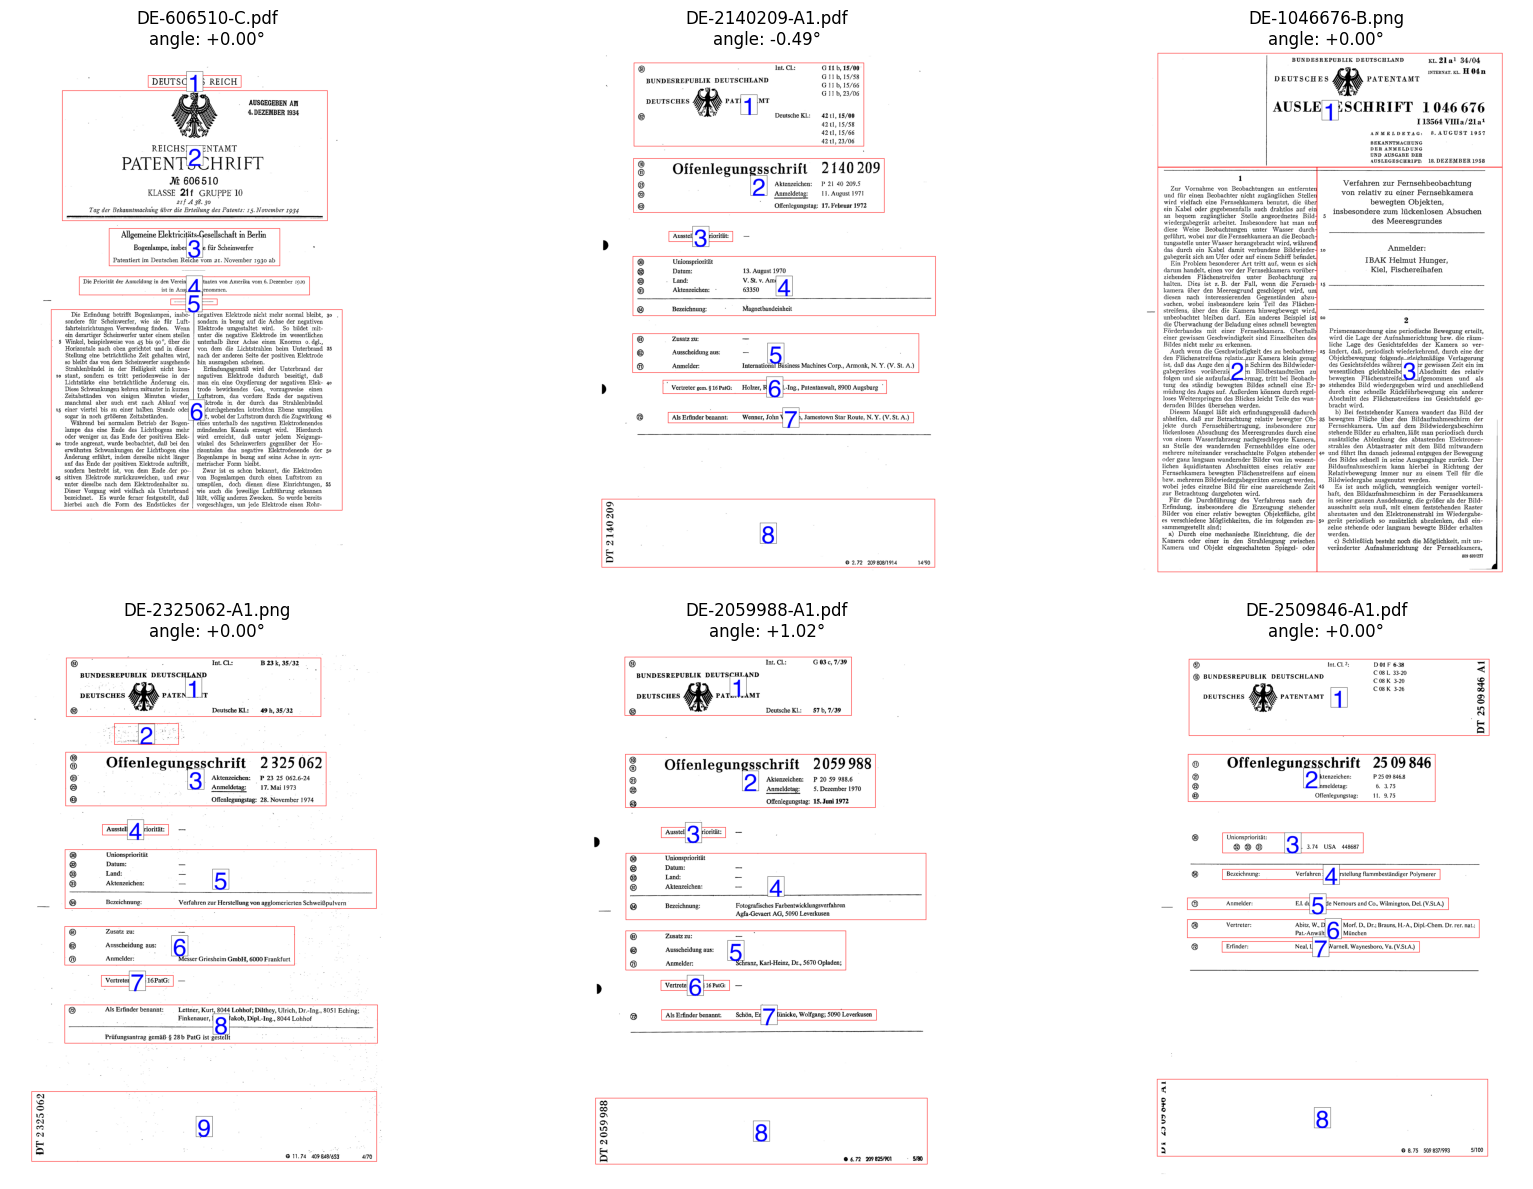

In [1]:
import random
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
import secrets
SEED = secrets.randbelow(10**9)
# SEED = 3598985
SEED = 86857199
random.seed(SEED)
print("Seed générée :", SEED)


from pdf2image import convert_from_path  # nécessaire pour les PDF


BASE_PATH = Path("data/gold_standard_DE/PNGs_extracted")

def load_image(path):
    """Charge un PNG ou la première page d'un PDF."""
    if path.suffix.lower() == ".png":
        return Image.open(path).convert("RGB")
    elif path.suffix.lower() == ".pdf":
        pages = convert_from_path(path, dpi=300, first_page=1, last_page=1)
        return pages[0].convert("RGB")
    else:
        raise ValueError(f"Format non supporté : {path}")

def deskew_image_v2(pil_img, max_angle=15.0, margin_crop=0.2, return_angle=False):
    """
    - enlève les marges (haut/bas/gauche/droite)
    - détecte le contour principal
    - applique minAreaRect uniquement sur ce contour (plus précis)
    - deskew sur l’image entière à partir de cet angle

    Si return_angle=True, renvoie (image, angle_applique_deg).
    """
    gray = np.array(pil_img.convert("L"))

    # 1) Crop léger pour ignorer marges blanches parasites
    h, w = gray.shape
    dy = int(h * margin_crop)
    dx = int(w * margin_crop)

    roi = gray[dy:h-dy, dx:w-dx]   # zone centrale seulement

    # 2) Binarisation + inversion
    _, bw = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bw = cv2.bitwise_not(bw)

    # 3) Trouver le plus gros contour (bloc principal)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return (pil_img, 0.0) if return_angle else pil_img

    big = max(contours, key=cv2.contourArea)

    # 4) minAreaRect sur ce seul contour
    rect = cv2.minAreaRect(big)
    angle = rect[-1]

    # correction standard minAreaRect
    angle = -(90 + angle) if angle < -45 else -angle

    # angle trop faible / trop grand → ne pas corriger
    if abs(angle) < 0.1 or abs(angle) > max_angle:
        return (pil_img, 0.0) if return_angle else pil_img

    # 5) appliquer l'angle sur l'image entière
    img_cv = np.array(pil_img.convert("RGB"))
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(
        img_cv, M, (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE
    )

    out = Image.fromarray(rotated)
    return (out, float(angle)) if return_angle else out


def crop_to_content(pil_img, pad=20, min_area=500, min_ink_frac=0.001):
    gray = np.array(pil_img.convert("L"))
    h, w = gray.shape
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ink = (bw == 0).astype(np.uint8)

    if ink.mean() < min_ink_frac:
        return pil_img

    num, labels, stats, _ = cv2.connectedComponentsWithStats(ink, connectivity=8)

    keep = np.zeros_like(ink)
    for i in range(1, num):
        x, y, ww, hh, area = stats[i]
        if area < min_area:
            continue
        touches_border = (x == 0) or (y == 0) or (x + ww >= w) or (y + hh >= h)
        if touches_border:
            continue
        keep[labels == i] = 1

    if keep.sum() == 0:
        return pil_img  # fallback

    ys, xs = np.where(keep > 0)
    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(w - 1, x2 + pad); y2 = min(h - 1, y2 + pad)

    return pil_img.crop((x1, y1, x2 + 1, y2 + 1))


def estimate_skew_angle_hough(pil_img, max_angle=20.0):
    gray = np.array(pil_img.convert("L"))
    # léger blur pour stabiliser
    g = cv2.GaussianBlur(gray, (3,3), 0)

    edges = cv2.Canny(g, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=120,
                            minLineLength=int(min(gray.shape)*0.25),
                            maxLineGap=20)
    if lines is None:
        return 0.0

    angles = []
    for x1,y1,x2,y2 in lines[:,0]:
        dx, dy = (x2-x1), (y2-y1)
        if dx == 0:
            continue
        ang = np.degrees(np.arctan2(dy, dx))
        # on veut les lignes proches de l'horizontale
        if abs(ang) <= max_angle:
            angles.append(ang)

    if len(angles) < 5:
        return 0.0

    return float(np.median(angles))

def deskew_image_v3(pil_img, max_angle=15.0, pad=150, return_angle=False):
    """
    1) crop_to_content pour virer les bordures parasites
    2) estimation angle par Hough (plus robuste que biggest contour)
    3) rotation appliquée sur l'image entière (pas juste le crop)
    """
    # 1) Crop pour calculer un angle propre
    cropped = crop_to_content(pil_img, pad=pad)

    # 2) Angle
    angle = estimate_skew_angle_hough(cropped, max_angle=max_angle)

    if abs(angle) < 0.1 or abs(angle) > max_angle:
        return (pil_img, 0.0) if return_angle else pil_img

    # 3) Rotate original
    img_cv = np.array(pil_img.convert("RGB"))
    h, w = img_cv.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img_cv, M, (w, h),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)

    out = Image.fromarray(rotated)
    return (out, float(angle)) if return_angle else out

# ============================
# SEGMENTATION V6 (clean + debug-friendly)
# - Keep your "vision" segmentation core
# - Fix small-box filtering with ink + connected-components
# - Trigger fallback split on a DOMINANT big box (even if other boxes exist)
# - Split BEFORE merge (so split isn't immediately destroyed)
# - Keep functions separated for future-you
# ============================

import numpy as np
import cv2
from PIL import Image

# ----------------------------
# Helpers: geometry
# ----------------------------
def box_area(b):
    x1, y1, x2, y2 = b
    return max(0, x2 - x1) * max(0, y2 - y1)

def box_wh(b):
    x1, y1, x2, y2 = b
    return max(0, x2 - x1), max(0, y2 - y1)

def get_dominant_box_idx(boxes):
    if not boxes:
        return None
    areas = [box_area(b) for b in boxes]
    return int(np.argmax(areas))

# ----------------------------
# Helpers: binarization / ink mask
# ----------------------------
def make_ink_mask(gray):
    """
    Returns ink_clean (uint8 0/1) where 1 means "ink/text".
    Uses Otsu + light morphological open to remove salt & pepper grain.
    """
    _, bw_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ink = (bw_otsu == 0).astype(np.uint8)  # 1 = ink
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    ink_clean = cv2.morphologyEx(ink, cv2.MORPH_OPEN, k, iterations=1)
    return ink_clean

def make_cc_maps(ink_clean):
    """
    Connected-components over ink mask.
    Returns (labels_cc, stats_cc) where:
      - labels_cc: int label per pixel
      - stats_cc: per-component stats [x,y,w,h,area], label 0 is background
    """
    ink255 = (ink_clean * 255).astype(np.uint8)
    num_cc, labels_cc, stats_cc, _ = cv2.connectedComponentsWithStats(ink255, connectivity=8)
    return labels_cc, stats_cc


# ----------------------------
# Helpers: small-box filtering (robust)
# ----------------------------
def inner_crop_coords(x1, y1, x2, y2, inner_frac=0.08):
    """
    Returns coords of an inner rectangle to reduce border noise.
    """
    w = x2 - x1
    h = y2 - y1
    mx = int(inner_frac * w)
    my = int(inner_frac * h)

    xx1 = min(x2 - 1, x1 + mx)
    yy1 = min(y2 - 1, y1 + my)
    xx2 = max(xx1 + 1, x2 - mx)
    yy2 = max(yy1 + 1, y2 - my)
    return xx1, yy1, xx2, yy2

def is_valid_small_box(
    b,
    H, W,
    ink_clean,
    labels_cc,
    min_ink_ratio=0.0018,
    min_blob_area=25,
    min_significant_blobs=2,
    inner_frac=0.08,
):
    """
    Decide if a SMALL box contains meaningful content.
    Uses:
      - ink density inside an inner crop
      - number of connected-component blobs above a minimum area
    """
    x1, y1, x2, y2 = b
    xx1, yy1, xx2, yy2 = inner_crop_coords(x1, y1, x2, y2, inner_frac=inner_frac)

    crop_ink = ink_clean[yy1:yy2, xx1:xx2]
    if crop_ink.size == 0:
        return False

    ink_ratio = float(crop_ink.mean())
    if ink_ratio < min_ink_ratio:
        return False

    roi_labels = labels_cc[yy1:yy2, xx1:xx2]
    roi_labels = roi_labels[roi_labels > 0]
    if roi_labels.size == 0:
        return False

    uniq, counts = np.unique(roi_labels, return_counts=True)
    significant = int(np.sum(counts >= min_blob_area))
    if significant < min_significant_blobs:
        return False

    return True


# ----------------------------
# Helpers: nested removal
# ----------------------------
def remove_nested_boxes(boxes, iou_thresh=0.7):
    """
    Remove a box A if it's mostly inside a bigger box B:
      inter/areaA > iou_thresh and areaA < areaB
    """
    nested_cleaned = []
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        areaA = box_area([x1, y1, x2, y2])
        if areaA <= 0:
            continue

        keep = True
        for j, (X1, Y1, X2, Y2) in enumerate(boxes):
            if i == j:
                continue

            areaB = box_area([X1, Y1, X2, Y2])
            if areaB <= 0:
                continue

            ix1 = max(x1, X1)
            iy1 = max(y1, Y1)
            ix2 = min(x2, X2)
            iy2 = min(y2, Y2)
            inter = max(0, ix2 - ix1) * max(0, iy2 - iy1)

            if (inter / areaA) > iou_thresh and areaA < areaB:
                keep = False
                break

        if keep:
            nested_cleaned.append([x1, y1, x2, y2])

    return nested_cleaned


# ----------------------------
# Helpers: fallback split (your existing refine_big_block)
# ----------------------------
def needs_fallback(final, H, W, area_ratio=0.50):
    if len(final) == 1:
        x1,y1,x2,y2 = final[0]
        area = (x2-x1)*(y2-y1)
        if area / (H*W) > area_ratio:
            return True
    return False

def refine_big_block(pil_img, block,
                     title_ratio=0.22,
                     valley_rel_thresh=0.75):
    """
    Fallback quand on a une seule énorme box.
    - Coupe en haut un bandeau de hauteur = title_ratio du bloc (titre/logo).
    - Sur le reste, détecte 1 ou 2 colonnes via projection verticale.
    Retourne 2 ou 3 boxes.
    """

    x1, y1, x2, y2 = block
    crop = np.array(pil_img.crop((x1, y1, x2, y2)).convert("L"))
    H, W = crop.shape

    # 1) Titre = bandeau haut fixe (22 % du bloc par défaut)
    title_h = max(60, int(H * title_ratio))
    title_h = min(title_h, H - 60)  # sécurité
    title_box = [x1, y1, x2, y1 + title_h]

    # 2) Corps de texte (le reste)
    body = crop[title_h:, :]
    body_y0 = y1 + title_h
    Hb, Wb = body.shape

    # 3) Projection verticale pour voir s'il y a 1 ou 2 colonnes
    vproj = np.sum(body < 200, axis=0)

    # on ignore les 10% de bords gauche/droite (bruit)
    margin = max(5, int(0.10 * Wb))
    inner = vproj[margin:Wb - margin]
    if inner.size == 0:
        # fallback : tout en une colonne
        return [title_box, [x1, body_y0, x2, y2]]

    max_val = inner.max()
    min_idx = inner.argmin() + margin
    min_val = inner[min_idx - margin]

    # profondeur de la vallée au centre
    has_two_cols = (max_val > 0) and (min_val / max_val < valley_rel_thresh)

    boxes = [title_box]

    if has_two_cols:
        # split à la vallée centrale
        split_x = min_idx
        # colonne gauche
        boxes.append([x1, body_y0, x1 + split_x, y2])
        # colonne droite
        boxes.append([x1 + split_x, body_y0, x2, y2])
    else:
        # une seule grosse colonne
        boxes.append([x1, body_y0, x2, y2])

    return boxes


# ----------------------------
# Merge + ordering (use your existing ones)
# NOTE: I keep your functions as-is, but recommended to replace merge later.
# ----------------------------
def merge_boxes_horizontally(boxes,min_vertical_overlap=0.3):
    """
    Fusionne les boîtes qui ont un chevauchement vertical significatif.

    Args:
        boxes: liste de [x1, y1, x2, y2]
        min_vertical_overlap: ratio minimum de chevauchement vertical (0.3 = 30%)

    Returns:
        Liste de boîtes fusionnées, triées de haut en bas
    """
    if not boxes:
        return []

    # Trier par Y (haut en bas)
    boxes_sorted = sorted(boxes, key=lambda b: b[1])

    # Grouper en bandes avec chevauchement vertical
    bands = []
    current_band = [boxes_sorted[0]]

    for box in boxes_sorted[1:]:
        x1, y1, x2, y2 = box

        # Vérifier le chevauchement avec chaque boîte de la bande actuelle
        has_overlap = False

        for ref_box in current_band:
            X1, Y1, X2, Y2 = ref_box

            # Calculer le chevauchement vertical
            overlap_y1 = max(y1, Y1)
            overlap_y2 = min(y2, Y2)
            overlap_height = max(0, overlap_y2 - overlap_y1)

            # Hauteur de la plus petite boîte
            h1 = y2 - y1
            h2 = Y2 - Y1
            min_height = min(h1, h2)

            # Si chevauchement >= 30% de la plus petite hauteur
            if min_height > 0 and (overlap_height / min_height) >= min_vertical_overlap:
                has_overlap = True
                break

        if has_overlap:
            current_band.append(box)
        else:
            bands.append(current_band)
            current_band = [box]

    bands.append(current_band)

    # Fusionner chaque bande en une seule boîte
    merged_boxes = []
    for band in bands:
        x1_min = min(b[0] for b in band)
        y1_min = min(b[1] for b in band)
        x2_max = max(b[2] for b in band)
        y2_max = max(b[3] for b in band)

        merged_boxes.append([x1_min, y1_min, x2_max, y2_max])

    return merged_boxes

def merge_boxes_brutal(boxes, overlap_thresh=0.15):
    merged = True
    boxes = [list(b) for b in boxes]
    while merged:
        merged = False
        new = []
        used = set()

        for i in range(len(boxes)):
            if i in used:
                continue

            x1,y1,x2,y2 = boxes[i]
            B = [x1,y1,x2,y2]

            for j in range(i+1, len(boxes)):
                if j in used:
                    continue

                X1,Y1,X2,Y2 = boxes[j]

                inter_w = max(0, min(B[2], X2) - max(B[0], X1))
                inter_h = max(0, min(B[3], Y2) - max(B[1], Y1))
                inter = inter_w * inter_h
                areaA = box_area(B)
                areaB = box_area([X1,Y1,X2,Y2])

                if inter > 0 and areaA > 0 and areaB > 0 and (
                    inter/areaA > overlap_thresh or inter/areaB > overlap_thresh
                ):
                    B = [min(B[0], X1), min(B[1], Y1), max(B[2], X2), max(B[3], Y2)]
                    used.add(j)
                    merged = True

                # NOTE: your "touchY" merge is risky; keep for now but consider constraining later
                if abs(B[1] - Y2) < 20 or abs(B[3] - Y1) < 20:
                    B = [min(B[0], X1), min(B[1], Y1), max(B[2], X2), max(B[3], Y2)]
                    used.add(j)
                    merged = True

            used.add(i)
            new.append(B)

        boxes = new
    return boxes


# ----------------------------
# Core: segmentation V6
# ----------------------------
def segment_document_v6(
    pil_img,
    min_contour_area=3000,
    iou_thresh=0.7,
    big_min_w=100,
    big_min_h=100,
    fallback_area_ratio=0.55,
    small_min_ink_ratio=0.0018,
    small_min_blob_area=25,
    small_min_significant_blobs=2,
    inner_frac=0.08,
    debug=False
):
    """
    V6 changes vs V5:
      - Build ink_clean + CC maps once
      - Small-box filtering uses ink + CC blobs (reduces "tiny garbage boxes")
      - Fallback triggers on dominant big box (not only when len==1)
      - Fallback split happens BEFORE merge
    """

    # --- grayscale ---
    gray = np.array(pil_img.convert("L"))
    H, W = gray.shape

    # --- ink mask branch (for filtering decisions) ---
    ink_clean = make_ink_mask(gray)
    labels_cc, stats_cc = make_cc_maps(ink_clean)

    # --- your vision segmentation branch ---
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
    inv = 255 - gray_blur
    blurred = cv2.GaussianBlur(inv, (41,41), 0)

    blocks = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        101, -10
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
    closed = cv2.morphologyEx(blocks, cv2.MORPH_CLOSE, kernel)

    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (50,25))
    fused = cv2.dilate(closed, kernel_line, iterations=1)

    contours, _ = cv2.findContours(fused, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h < min_contour_area:
            continue
        boxes.append([x, y, x + w, y + h])

    # --- nested removal ---
    nested_cleaned = remove_nested_boxes(boxes, iou_thresh=iou_thresh)

    # --- small box filtering (robust) ---
    final = []
    for b in nested_cleaned:
        w, h = box_wh(b)

        # keep big boxes directly
        if w > big_min_w and h > big_min_h:
            final.append(b)
            continue

        # keep only if ink + blobs indicate meaningful content
        if is_valid_small_box(
            b, H, W,
            ink_clean=ink_clean,
            labels_cc=labels_cc,
            min_ink_ratio=small_min_ink_ratio,
            min_blob_area=small_min_blob_area,
            min_significant_blobs=small_min_significant_blobs,
            inner_frac=inner_frac
        ):
            final.append(b)


    # --- merge + order ---
    boxes2 = merge_boxes_brutal(final)
    final_sorted = merge_boxes_horizontally(boxes2, min_vertical_overlap=0.2)
    # final_sorted = boxes2
    # --- fallback split on dominant huge box (BEFORE merge) ---
    if needs_fallback(final_sorted, H, W):
        print("Fallback split triggered")
        final_sorted = refine_big_block(pil_img, final_sorted[0])
    out = {
        "gray": gray,
        "blurred": blurred,
        "blocks": blocks,
        "closed": closed,
        "lines": fused,
        "ink_clean": ink_clean
    }

    if debug:
        print(len(boxes), "boxes found")
        print(len(nested_cleaned), "after nested removal")
        print(len(final), "after small filtering + optional fallback split (pre-merge)")
        print(len(boxes2), "after merge")
        print(len(final_sorted), "final sorted")

    return out, final_sorted
# ============================
# Ordering
# ============================
def order_boxes_geometric(boxes, vertical_overlap_threshold=0.3):
    """
    Ordonne les boîtes de manière géométrique pure, sans heuristique sur le nombre.

    Principe :
    1. Groupe les boîtes qui ont un chevauchement vertical significatif (= même "ligne")
    2. Pour chaque ligne : trie de gauche à droite
    3. Les lignes sont triées de haut en bas

    Args:
        boxes: liste de [x1, y1, x2, y2]
        vertical_overlap_threshold: ratio de chevauchement vertical pour être sur la même ligne

    Returns:
        Liste ordonnée selon le flux de lecture naturel
    """
    if not boxes:
        return []

    if len(boxes) == 1:
        return boxes

    # Trier par Y pour commencer par le haut
    boxes_sorted = sorted(boxes, key=lambda b: b[1])

    # Grouper en "lignes" basées sur le chevauchement vertical
    lines = []
    current_line = [boxes_sorted[0]]

    for box in boxes_sorted[1:]:
        x1, y1, x2, y2 = box

        # Vérifier le chevauchement vertical avec TOUTES les boîtes de la ligne actuelle
        has_overlap = False

        for ref_box in current_line:
            X1, Y1, X2, Y2 = ref_box

            # Chevauchement vertical
            overlap_y1 = max(y1, Y1)
            overlap_y2 = min(y2, Y2)
            overlap_height = max(0, overlap_y2 - overlap_y1)

            h1 = y2 - y1
            h2 = Y2 - Y1
            min_height = min(h1, h2)

            # Si chevauchement >= threshold, c'est la même ligne
            if min_height > 0 and (overlap_height / min_height) >= vertical_overlap_threshold:
                has_overlap = True
                break

        if has_overlap:
            current_line.append(box)
        else:
            # Nouvelle ligne
            lines.append(current_line)
            current_line = [box]

    lines.append(current_line)

    # Pour chaque ligne : trier de gauche à droite (par x1)
    result = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0])
        result.extend(line_sorted)

    return result

# ============================
# 0. Draw functions
# ============================

def draw_boxes(pil_img, boxes, color="red", width=3):
    """Dessine les bounding boxes sur une copie de l'image."""
    out = pil_img.copy()
    draw = ImageDraw.Draw(out)
    for (x1,y1,x2,y2) in boxes:
        draw.rectangle([x1,y1,x2,y2], outline=color, width=width)
    return out


def draw_ordering_numbers(pil_img, boxes, font_size=60, color="red"):
    """
    Dessine les numéros d'ordre au centre de chaque boîte.

    Args:
        pil_img: image PIL
        boxes: liste ordonnée de [x1, y1, x2, y2]
        font_size: taille de la police
        color: couleur du texte

    Returns:
        Image PIL avec les numéros dessinés
    """
    out = pil_img.copy()
    draw = ImageDraw.Draw(out)

    # Essayer de charger une grosse police
    try:
        from PIL import ImageFont
        # Essayer plusieurs chemins de police selon l'OS
        font_paths = [
            "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",  # Linux
            "/System/Library/Fonts/Helvetica.ttc",  # macOS
            "C:\\Windows\\Fonts\\arialbd.ttf",  # Windows
            "arial.ttf"
        ]
        font = None
        for font_path in font_paths:
            try:
                font = ImageFont.truetype(font_path, font_size)
                break
            except:
                continue
        if font is None:
            font = ImageFont.load_default()
    except:
        font = None

    for idx, (x1, y1, x2, y2) in enumerate(boxes, start=1):
        # Centre de la boîte
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        text = str(idx)

        # Obtenir taille du texte
        if font:
            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
        else:
            # Approximation si pas de font
            text_width = len(text) * 20
            text_height = 30

        # Position du texte (centré)
        text_x = cx - text_width // 2
        text_y = cy - text_height // 2

        # Fond blanc pour lisibilité
        padding = 10
        draw.rectangle(
            [text_x - padding, text_y - padding,
             text_x + text_width + padding, text_y + text_height + padding],
            fill="white",
            outline="black",
            width=2
        )

        # Dessiner le numéro
        if font:
            draw.text((text_x, text_y), text, fill=color, font=font)
        else:
            draw.text((text_x, text_y), text, fill=color)

    return out


# --------------------------
# 1. Lister les fichiers
# --------------------------

files = list(BASE_PATH.glob("**/*"))
files = [f for f in files if f.suffix.lower() in [".png",".pdf"]]

print(f"Total fichiers trouvés : {len(files)}")

# --------------------------
# 2. Choisir 6 fichiers random
# --------------------------
# random.seed(43)
sample_files = random.sample(files, 6)
print("Fichiers sélectionnés :")
for s in sample_files:
    print(" -", s)

# --------------------------
# 3. Pipeline pour les 6 fichiers
# --------------------------

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, path in zip(axes, sample_files):
    img = load_image(path)
    print(f"Processing {path.name}...")
    # deskew
    img_deskew, deskewed_angle = deskew_image_v3(img, max_angle=20.0, return_angle=True)
    # img_deskew = smart_deskew(img)
    # segmentation
    _, boxes = segment_document_v6(img_deskew)
    boxes_ordered = order_boxes_geometric(boxes, vertical_overlap_threshold=0.3)
    # overlay
    img_overlay = draw_boxes(img_deskew, boxes, color="red", width=3)
    img_final = draw_ordering_numbers(img_overlay, boxes_ordered, font_size=160, color="blue")

    # affichage
    # ax.imshow(img_deskew)
    ax.imshow(img_final)
    ax.set_title(f"{path.name}\nangle: {deskewed_angle:+.2f}°")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [2]:
# Jupyter cell (placée au même niveau que `src/`)
# Objectif:
#  - utiliser CustomSegmentation pour préprocesser le document
#  - utiliser OcrEngine pour faire l'OCR des blocs
#  - aucune fonction wrapper : orchestration explicite dans la cellule

import sys
from pathlib import Path

# -------------------------------------------------------------------
# 1) S'assurer que `src/` est dans le PYTHONPATH
# -------------------------------------------------------------------
ROOT = Path.cwd()   # notebook au même niveau que src/
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# -------------------------------------------------------------------
# 2) Imports depuis le package
# -------------------------------------------------------------------
from patent_pipeline.patent_ocr.custom_segmentation import CustomSegmentation
from patent_pipeline.patent_ocr.ocr_engine import OcrEngine


# -------------------------------------------------------------------
# 3) Configuration OCR (backend + paramètres)
# -------------------------------------------------------------------
# Ici : Tesseract simple, niveaux de gris, config explicite
ocr_config = {
    "lang": "frk+deu+eng",
    "config": "--psm 4 --oem 1 -c preserve_interword_spaces=1",
    "preprocess": "light",   # "light", "gray" | "otsu" | "none"
}

ocr_engine = OcrEngine(ocr_name="tesseract")


# -------------------------------------------------------------------
# 4) Préprocess document (load + deskew + segmentation + ordering)
# -------------------------------------------------------------------
doc_path = "data/gold_standard_DE/PNGs_extracted/DE-1123987-B.png"  # à adapter

segmenter = CustomSegmentation()

res = segmenter.process(
    doc_path,
    deskew_max_angle=20.0,
    return_debug=False,
)

page_img = res["image"]
boxes = res["boxes_ordered"]

print(f"Nombre de blocs détectés : {len(boxes)}")


# -------------------------------------------------------------------
# 5) OCR bloc par bloc
# -------------------------------------------------------------------
blocks_text = []

for (x1, y1, x2, y2) in boxes:
    block_img = page_img.crop((x1, y1, x2, y2))
    txt = ocr_engine.run_ocr(block_img, ocr_config)
    if txt:
        blocks_text.append(txt)

# Reconstruction simple
full_text = "\n\n".join(blocks_text)


# -------------------------------------------------------------------
# 6) Résultat
# -------------------------------------------------------------------
print(full_text)
print("\n---")
print(f"Nb blocs OCRisés : {len(blocks_text)}")


Nombre de blocs détectés : 3
BUNDESREPUBLIK DEUTSCHLAND     K1.84c 7/30

INTERNAT.KL. E, 02 d
onurscus FIR PATENTAMT

AUSLEGESCHRIFT 11239587

C 13062 V/84c

ANMELDETAG: 23. MAI 1956

BEKANNTMACHUNG
DER ANMELDUNG
UND AUSGABE DER
ATSTEGCGESCHRIFT: 15. FEBRUAR 1962

1

Die Erfindung betrifft einen ausdehnbaren Ein-
treibkern zum Einbringen von Hohlpfählen, Vortreib-
rohren od. dgl. in das Erdreich, der eine Anzahl von
radial beweglichen Längssektoren, einen Mittelkern,
aufpumpbare Schläuche zur Radialverlagerung der
Längssektoren nach außen hinsichtlich des Mittel-
kernes und elastische Rückzugsteile zur Verlagerung
der Längssektoren zum Mittelkern hin aufweist.

Bei einem bekannten Eintreibkern dieser Art ist
jeder Längssektor mit einem kleinen Längsflügel in
Form eines Hakens versehen, der mit einem ent-
sprechenden, auf dem Mittelkern angebrachten Flü-
gel zusammenarbeitet und mit diesem zwei Kammern
bildet, die sich radial folgen. Dabei ist in der einen
Kammer ein ausdehnbares, aufpu

In [3]:
# Jupyter cell — Test TesseractBackend (backend-only architecture)

import sys
from pathlib import Path

ROOT = Path.cwd()
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from patent_pipeline.patent_ocr.custom_segmentation import CustomSegmentation
from patent_pipeline.patent_ocr.deskewer import Deskewer
from patent_pipeline.patent_ocr.pipeline_modular import (
    Pipeline_OCR,
    PipelineOCRConfig,
    write_report_csv,
)
from patent_pipeline.patent_ocr.backends.tesseract_backend import TesseractBackend


# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
raw_dir = Path("data/gold_standard_DE/PNGs_extracted")

out_dir_custom = Path("data/gold_standard_DE/ocr_text_tesseract_backend_custom")
report_custom = Path("data/gold_standard_DE/ocr_report_tesseract_backend_custom.csv")

out_dir_backend = Path("data/gold_standard_DE/ocr_text_tesseract_backend_page")
report_backend = Path("data/gold_standard_DE/ocr_report_tesseract_backend_page.csv")


# -------------------------------------------------------------------
# Instantiate components
# -------------------------------------------------------------------
deskewer = Deskewer(method="hough")

segmenter = CustomSegmentation(
    deskewer=deskewer,
    deskew_max_angle=20.0,
)

tesseract_backend = TesseractBackend()

pipeline = Pipeline_OCR(
    ocr_backend=tesseract_backend,
    segmenter=segmenter,   # used only in segmentation_mode="custom"
    deskewer=deskewer,     # page-level deskew
)

ocr_config = {
    "lang": "frk+deu",
    "config": "--psm 3 --oem 1 -c preserve_interword_spaces=1",
    "preprocess": "light",
}


# -------------------------------------------------------------------
# 1) Tesseract + CUSTOM segmentation
# -------------------------------------------------------------------
cfg_custom = PipelineOCRConfig(
    raw_dir=raw_dir,
    out_dir=out_dir_custom,
    report_file=report_custom,
    segmentation_mode="custom",
    deskew=True,
    deskew_max_angle=20.0,
    ocr_config=ocr_config,
    workers=10,
    parallel="threads",
    limit=10,
    force=True,
)

rows_custom = pipeline.run(cfg_custom)
write_report_csv(cfg_custom.report_file, rows_custom)
print("✅ TesseractBackend CUSTOM done:", cfg_custom.report_file)


# -------------------------------------------------------------------
# 2) Tesseract + BACKEND mode (page entière)
# -------------------------------------------------------------------
cfg_backend = PipelineOCRConfig(
    raw_dir=raw_dir,
    out_dir=out_dir_backend,
    report_file=report_backend,
    segmentation_mode="backend",
    deskew=True,
    deskew_max_angle=20.0,
    ocr_config=ocr_config,
    workers=1,
    parallel="none",
    limit=5,
    force=True,
)

rows_backend = pipeline.run(cfg_backend)
write_report_csv(cfg_backend.report_file, rows_backend)
print("✅ TesseractBackend PAGE done:", cfg_backend.report_file)


# -------------------------------------------------------------------
# Quick sanity check: print one file
# -------------------------------------------------------------------
sample_txt = next(out_dir_custom.glob("*.txt"))
print("\n--- SAMPLE OUTPUT ---")
print(sample_txt)
print(sample_txt.read_text(encoding="utf-8")[:1200])


 - DE-1004283-B.png: ok (3/3)
 - DE-100639-C.png: ok (5/6)
 - DE-1004639-B.png: ok (2/2)
 - DE-1001198-B.png: ok (3/3)
 - DE-1004991-B.png: ok (3/3)
 - DE-1003756-B.png: ok (3/3)
 - DE-1005455-B.png: ok (3/3)
 - DE-1001723-B.png: ok (3/3)
 - DE-1004590-B.png: ok (3/3)
 - DE-1005702-B.png: ok (2/2)
✅ TesseractBackend CUSTOM done: data/gold_standard_DE/ocr_report_tesseract_backend_custom.csv
 - DE-1001198-B.png: ok (1/1)
 - DE-1001723-B.png: ok (1/1)
 - DE-1003756-B.png: ok (1/1)
 - DE-1004283-B.png: ok (1/1)
 - DE-1004590-B.png: ok (1/1)
✅ TesseractBackend PAGE done: data/gold_standard_DE/ocr_report_tesseract_backend_page.csv

--- SAMPLE OUTPUT ---
data/gold_standard_DE/ocr_text_tesseract_backend_custom/DE-1001198-B.txt
KL.88b          2
BUNDESREPUBLIK DEUTSCHLAND

INTERNAT. KL. F 03€
DEUTSCHES M PATENTAMT

AUSLEGESCHRIFT 1001198

Sch 17940 Ia/88b
ANMELDETAG: 11 MAI 1955
BEKANNTMACHUNG
DER ANMELDUNG

UND AUSGABE DER
AUSLEGESCHRIFT: 17. JANUAR 1957

1

Bei Drehkolbenmaschinen mit bewegba

In [2]:
# Jupyter cell — Test DocTR backend (backend-only OCR architecture)

import sys
from pathlib import Path

ROOT = Path.cwd()
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from patent_pipeline.patent_ocr.deskewer import Deskewer
from patent_pipeline.patent_ocr.pipeline_modular import (
    Pipeline_OCR,
    PipelineOCRConfig,
    write_report_csv,
)
from patent_pipeline.patent_ocr.backends.doctr_backend import DocTROcrBackend


# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
raw_dir = Path("data/gold_standard_DE/PNGs_extracted")

out_dir = Path("data/gold_standard_DE/ocr_text_doctr_backend")
report_file = Path("data/gold_standard_DE/ocr_report_doctr_backend.csv")


# -------------------------------------------------------------------
# Choose device (IMPORTANT)
# -------------------------------------------------------------------
# Mac Apple Silicon:
DEVICE = "mps"

# Linux + NVIDIA:
# DEVICE = "cuda"

# CPU fallback:
# DEVICE = "cpu"


# -------------------------------------------------------------------
# Instantiate components
# -------------------------------------------------------------------
deskewer = Deskewer(method="hough")

doctr_backend = DocTROcrBackend(
    device=DEVICE,
    det_arch="db_resnet50",
    reco_arch="crnn_vgg16_bn",
    pretrained=True,
)

pipeline = Pipeline_OCR(
    ocr_backend=doctr_backend,
    segmenter=None,      # ignored in segmentation_mode="backend"
    deskewer=deskewer,   # page-level deskew STILL applies
)

cfg = PipelineOCRConfig(
    raw_dir=raw_dir,
    out_dir=out_dir,
    report_file=report_file,
    segmentation_mode="backend",  # docTR does detection + ordering
    deskew=True,
    deskew_max_angle=20.0,
    ocr_config={
        # possible overrides later
        # "det_arch": "...",
        # "reco_arch": "...",
    },
    workers=1,           # GPU => ALWAYS start with 1
    parallel="none",
    limit=10,
    force=True,
)

# -------------------------------------------------------------------
# Run
# -------------------------------------------------------------------
rows = pipeline.run(cfg)
write_report_csv(cfg.report_file, rows)
print("✅ DocTR backend OCR done:", cfg.report_file)


# -------------------------------------------------------------------
# Quick sanity check: print one output
# -------------------------------------------------------------------
sample_txt = next(out_dir.glob("*.txt"))
print("\n--- SAMPLE OUTPUT (DocTR) ---")
print(sample_txt)
print(sample_txt.read_text(encoding="utf-8")[:1200])


/Users/delville/code/Just-PH/patent_pipeline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 - DE-1001198-B.png: ok (1/1)
 - DE-1001723-B.png: ok (1/1)
 - DE-1003756-B.png: ok (1/1)
 - DE-1004283-B.png: ok (1/1)
 - DE-1004590-B.png: ok (1/1)
 - DE-1004639-B.png: ok (1/1)
 - DE-1004991-B.png: ok (1/1)
 - DE-1005455-B.png: ok (1/1)
 - DE-1005702-B.png: ok (1/1)
 - DE-100639-C.png: ok (1/1)
✅ DocTR backend OCR done: data/gold_standard_DE/ocr_report_doctr_backend.csv

--- SAMPLE OUTPUT (DocTR) ---
data/gold_standard_DE/ocr_text_doctr_backend/DE-1001198-B.txt
KL. 881 b
2
BUNDESREPUBLIK DEUTSCHLAND
INTERNAT. KL. F03e
DEUTSCHES
PATENTAMT
AUSLEGESCHRIFT 1001 - 198
Sch 17940Ia/88b
ANI M E LDE' TAG: 11. MAI 1955
BEKANNTMACHUNG
DER ANMELDUNG
UND AUSGABE DER
AUSLEGESCHRIFT: 17. JANUAR 1957
1
Drehkolbenmaschine
Bei Drehkolbenmaschinen mit bewegbaren Kolben
werden vielfach Drehkolben verwendet, die zeitweise
mit bewegbaren Kolben
durch einseitigen Flissigkeitsdruck gegen Flachen
ihres Fihrungskorpers, des Laufers oder des fest-
stehenden Gehauses gedrickt werden. Die Flache 5
eines Drehkol

In [6]:
# Jupyter cell — Test GOT-OCR2 backend (Transformers, MPS/CUDA/CPU) with CUSTOM segmentation

import sys
from pathlib import Path

ROOT = Path.cwd()
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from patent_pipeline.patent_ocr.custom_segmentation import CustomSegmentation
from patent_pipeline.patent_ocr.deskewer import Deskewer
from patent_pipeline.patent_ocr.pipeline_modular import Pipeline_OCR, PipelineOCRConfig, write_report_csv
from patent_pipeline.patent_ocr.backends.got_ocr_backend import GotOcrBackend


# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
raw_dir = Path("data/gold_standard_DE/PNGs_extracted")
out_dir = Path("data/gold_standard_DE/ocr_text_gotocr_custom_v1")
report_file = Path("data/gold_standard_DE/ocr_report_gotocr_custom_v1.csv")


# -------------------------------------------------------------------
# Device (choose one)
# -------------------------------------------------------------------
DEVICE = "mps"   # "cpu" | "mps" | "cuda" | "auto"


# -------------------------------------------------------------------
# Components
# -------------------------------------------------------------------
deskewer = Deskewer(method="hough")
segmenter = CustomSegmentation(deskewer=deskewer, deskew_max_angle=20.0)

got_backend = GotOcrBackend(
    device=DEVICE,
    model_id="stepfun-ai/GOT-OCR-2.0-hf",
    # dtype="float32",  # <- uncomment if MPS outputs are weird
    trust_remote_code=True,
)

pipeline = Pipeline_OCR(
    ocr_backend=got_backend,
    deskewer=deskewer,
)

cfg = PipelineOCRConfig(
    raw_dir=raw_dir,
    out_dir=out_dir,
    report_file=report_file,
    segmentation_mode="backend",  # use backend OCR on CUSTOM segments
    deskew=True,
    deskew_max_angle=20.0,
    ocr_config={
        "preprocess": "light",  # keep minimal like your old cell
        # optional tuning (leave commented at first)
        "max_new_tokens": 1024,
        # "stop_strings": "<|im_end|>",
        # "format": False,
    },
    workers=1,            # GPU/MPS: keep 1
    parallel="none",
    limit=10,
    force=True,
)

rows = pipeline.run(cfg)
write_report_csv(cfg.report_file, rows)
print("✅ GOT-OCR OCR done:", cfg.report_file)


# -------------------------------------------------------------------
# Quick sanity: print first non-empty output
# -------------------------------------------------------------------
txt_files = sorted(out_dir.glob("*.txt"))
print(f"Generated {len(txt_files)} txt files in {out_dir}")

for p in txt_files:
    s = p.read_text(encoding="utf-8").strip()
    if s:
        print("\n--- FIRST NON-EMPTY OUTPUT (GOT-OCR2) ---")
        print("File:", p.name)
        print(s[:1200])
        break
else:
    print("\n⚠️ All outputs are empty. Try:")
    print("  - ocr_config['preprocess']='none'")
    print("  - uncomment max_new_tokens=2048")
    print("  - GotOcrBackend(dtype='float32') on MPS")


 - DE-1001198-B.png: ok (1/1)
 - DE-1001723-B.png: ok (1/1)
 - DE-1003756-B.png: ok (1/1)
 - DE-1004283-B.png: ok (1/1)
 - DE-1004590-B.png: ok (1/1)
 - DE-1004639-B.png: ok (1/1)
 - DE-1004991-B.png: ok (1/1)
 - DE-1005455-B.png: ok (1/1)
 - DE-1005702-B.png: ok (1/1)
 - DE-100639-C.png: ok (1/1)
✅ GOT-OCR OCR done: data/gold_standard_DE/ocr_report_gotocr_custom_v1.csv
Generated 10 txt files in data/gold_standard_DE/ocr_text_gotocr_custom_v1

--- FIRST NON-EMPTY OUTPUT (GOT-OCR2) ---
File: DE-1001198-B.txt
BUNDESREPUBLIK DEUTSCHLAND
DEUTSCHES
PATENTAMT
Buch 17940 Ia/88b
11. MAI 1955
17. JANUAR 1957
1
Bei Drehkolbemnashcinen mit bewegbaren Kolben
werden vielfach Drehkolben verwendet, die zeitweise
durch einseitigen Flüssigkeitsdruck gegen Flächen
ihres Führungskörpers, des Läufers oder des fest-
stehenden Gehäuses gedrückt werden. Die Fläche
eines Drehkolbens nähert sich dabei der stützenden
Fläche des Führungskörpers, z. B. in den Schlitzen
durch einseitigen Fläche, die die Riesstrahl

In [1]:
# Jupyter cell — Test PaddleOCR backend (robust, Fraktur-friendly) with CUSTOM segmentation
# This cell matches the corrected PaddleOcrBackend (no show_log/use_gpu assumptions).

import sys
from pathlib import Path

# -------------------------------------------------------------------
# Ensure src/ is on PYTHONPATH
# -------------------------------------------------------------------
ROOT = Path.cwd()
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from patent_pipeline.patent_ocr.custom_segmentation import CustomSegmentation
from patent_pipeline.patent_ocr.deskewer import Deskewer
from patent_pipeline.patent_ocr.pipeline_modular import (
    Pipeline_OCR,
    PipelineOCRConfig,
    write_report_csv,
)
from patent_pipeline.patent_ocr.backends.paddleocr_backend import PaddleOcrBackend


# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
raw_dir = Path("data/gold_standard_DE/PNGs_extracted")
out_dir = Path("data/gold_standard_DE/ocr_text_paddle_de_custom_v3")
report_file = Path("data/gold_standard_DE/ocr_report_paddle_de_custom_v3.csv")


# -------------------------------------------------------------------
# Components
# -------------------------------------------------------------------
deskewer = Deskewer(method="hough")
segmenter = CustomSegmentation(deskewer=deskewer, deskew_max_angle=20.0)

# IMPORTANT:
# - lang="de" for German (works best on mixed Latin/Fraktur prints)
# - use_gpu intentionally NOT relied on (backend handles compatibility)
paddle_backend = PaddleOcrBackend(
    lang="de",
    use_angle_cls=False,
    use_gpu=False,
)

pipeline = Pipeline_OCR(
    ocr_backend=paddle_backend,
    segmenter=segmenter,
    deskewer=deskewer,
)

# -------------------------------------------------------------------
# OCR config (ROBUST FIRST, then optimize later)
# -------------------------------------------------------------------
cfg = PipelineOCRConfig(
    raw_dir=raw_dir,
    out_dir=out_dir,
    report_file=report_file,
    segmentation_mode="custom",
    deskew=True,
    deskew_max_angle=20.0,
    ocr_config={
        "preprocess": "none",       # 🔥 Fraktur-friendly; try "gray" only if needed
        "det": True,                # 🔥 REQUIRED for multi-line / complex blocks
        "rec": True,
        "cls": False,
        # Once validated, you MAY switch to:
        # "det": False,
        # "fallback_det_if_empty": True,
    },
    workers=1,                    # keep 1 on macOS
    parallel="none",
    limit=1,                      # 🔥 START WITH 1 to validate everything
    force=True,
)

rows = pipeline.run(cfg)
write_report_csv(cfg.report_file, rows)
print("✅ PaddleOCR OCR done:", cfg.report_file)


# -------------------------------------------------------------------
# Quick sanity check: show first non-empty output
# -------------------------------------------------------------------
txt_files = sorted(out_dir.glob("*.txt"))
print(f"Generated {len(txt_files)} txt files in {out_dir}")

for p in txt_files:
    s = p.read_text(encoding="utf-8").strip()
    if s:
        print("\n--- FIRST NON-EMPTY OUTPUT (PaddleOCR, lang=de, det=True) ---")
        print("File:", p.name)
        print(s[:1200])
        break
else:
    print("\n⚠️ Still empty. Next diagnostics to try:")
    print("  1) Keep det=True but switch preprocess -> 'gray'")
    print("  2) Smoke-test PaddleOCR on the FULL PAGE (no segmentation)")
    print("  3) Try PaddleOcrBackend(lang='en') for comparison")


/Users/delville/code/Just-PH/patent_pipeline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.
/Users/delville/code/Just-PH/patent_pipeline/.venv/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:712: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/delville/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creat

 - DE-1001198-B.png: error (0/0)
✅ PaddleOCR OCR done: data/gold_standard_DE/ocr_report_paddle_de_custom_v3.csv
Generated 1 txt files in data/gold_standard_DE/ocr_text_paddle_de_custom_v3

⚠️ Still empty. Next diagnostics to try:
  1) Keep det=True but switch preprocess -> 'gray'
  2) Smoke-test PaddleOCR on the FULL PAGE (no segmentation)
  3) Try PaddleOcrBackend(lang='en') for comparison


In [3]:
# Jupyter cell — PaddleOCR (YOUR version) smoke test with the CORRECT API call
# Your PaddleOCR.ocr(...) is deprecated and forwards to predict(...), and predict()
# DOES NOT accept det/rec/cls kwargs. So we call predict(img) directly.

import sys
from pathlib import Path

ROOT = Path.cwd()
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from PIL import Image
import numpy as np

from patent_pipeline.patent_ocr.backends.paddleocr_backend import PaddleOcrBackend


# -------------------------------------------------------------------
# Pick ONE file
# -------------------------------------------------------------------
img_path = Path("data/gold_standard_DE/PNGs_extracted/DE-1001198-B.png")
img_pil = Image.open(img_path).convert("RGB")
img_bgr = np.asarray(img_pil)[:, :, ::-1].copy()  # BGR uint8 (what Paddle expects)


# -------------------------------------------------------------------
# Build backend and access the underlying engine
# -------------------------------------------------------------------
backend = PaddleOcrBackend(lang="de", use_angle_cls=False, use_gpu=False)
backend._lazy_load()               # init
engine = backend._engine           # PaddleOCR instance


# -------------------------------------------------------------------
# ✅ Correct call for your PaddleOCR version:
# -------------------------------------------------------------------
res = engine.predict(img_bgr)      # <-- NO det/rec/cls kwargs


# -------------------------------------------------------------------
# Inspect result structure + try extracting text
# -------------------------------------------------------------------
print("Engine type:", type(engine))
print("Has predict:", hasattr(engine, "predict"))
print("Has ocr:", hasattr(engine, "ocr"))
print("Result type:", type(res))

# print a small preview of the structure (safe)
def preview(x, depth=0, max_depth=3):
    if depth > max_depth:
        return "..."
    if x is None:
        return None
    if isinstance(x, (str, int, float, bool)):
        return x
    if isinstance(x, dict):
        return {k: preview(v, depth+1, max_depth) for k, v in list(x.items())[:8]}
    if isinstance(x, (list, tuple)):
        return [preview(v, depth+1, max_depth) for v in list(x)[:5]]
    return repr(x)[:200]

print("\n--- Result preview ---")
print(preview(res))

# Use backend's generic extractor to pull strings out
texts = backend._extract_texts_generic(res)
txt = "\n".join(texts).strip()

print("\n--- Extracted text ---")
print("LEN:", len(txt))
print(txt[:1500] if txt else "[EMPTY]")


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/delville/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/delville/.paddlex/official_models/UVDoc`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/delville/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('latin_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/delville/.paddlex/official_models/latin_PP-OCRv5_mobile_rec`.


Engine type: <class 'paddleocr._pipelines.ocr.PaddleOCR'>
Has predict: True
Has ocr: True
Result type: <class 'list'>

--- Result preview ---
[{'input_path': None, 'page_index': None, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'input_img': 'array([[[255, ..., 255],\n        ...,\n        [255, ..., 255]],\n\n       ...,\n\n       [[255, ..., 255],\n        ...,\n        [255, ..., 255]]], shape=(3508, 2592, 3), dtype=uint8)', 'model_settings': {'use_doc_orientation_classify': '...', 'use_doc_unwarping': '...'}, 'angle': 0, 'rot_img': 'array([[[255, ..., 255],\n        ...,\n        [255, ..., 255]],\n\n       ...,\n\n       [[255, ..., 255],\n        ...,\n        [255, ..., 255]]], shape=(3508, 2592, 3), dtype=uint8)', 'output_img': 'array([[[255, ..., 255],\n        ...,\n        [255, ..., 255]],\n\n       ...,\n\n       [[255, ..., 255],\n        ...,\n        [255, ..., 255]]], shape=(3508, 2592, 3), dtype=uint8)'}, 'dt_polys': ['array([[1166,    0],\n       

In [2]:
import sys, site, subprocess, textwrap, os

print("Python:", sys.executable)
print("Version:", sys.version)
print("User site:", site.getusersitepackages())

print("\n--- pip (same interpreter) ---")
print(subprocess.check_output([sys.executable, "-m", "pip", "--version"]).decode())

print("\n--- show paddle packages (same interpreter) ---")
print(subprocess.run([sys.executable, "-m", "pip", "show", "paddleocr"], capture_output=True, text=True).stdout or "[no paddleocr]")
print(subprocess.run([sys.executable, "-m", "pip", "show", "paddlepaddle"], capture_output=True, text=True).stdout or "[no paddlepaddle]")


Python: /Users/delville/code/Just-PH/patent_pipeline/.venv/bin/python
Version: 3.12.7 (main, Oct 15 2025, 15:38:25) [Clang 17.0.0 (clang-1700.3.19.1)]
User site: /Users/delville/.local/lib/python3.12/site-packages

--- pip (same interpreter) ---
pip 25.2 from /Users/delville/code/Just-PH/patent_pipeline/.venv/lib/python3.12/site-packages/pip (python 3.12)


--- show paddle packages (same interpreter) ---
[no paddleocr]
[no paddlepaddle]


In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd()
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from patent_pipeline.pydantic_extraction.llm_extraction_agent import PatentExtractor

p = sorted(Path("data/gold_standard_DE/ocr_text_v2").glob("*.txt"))[0]
ocr_text = p.read_text(encoding="utf-8", errors="replace")

extractor = PatentExtractor(
    model_id="mlx-community/Mistral-7B-Instruct-v0.3",
    backend="mlx",
    verbose=True,
)

res = extractor.extract_one(ocr_text)
print("FILE:", p.name, "OK:", res.ok, "ERR:", res.error)
print("DETAILS:", res.error_details)
print("PRED:", None if not res.prediction else res.prediction.model_dump())
print("RAW(head):", (res.raw_output or "")[:800])


----- PROMPT(head) -----

Du bist ein Assistent, der strukturierte bibliographische Daten aus einem deutschen Patentdokument extrahiert.

Deine Aufgabe:
Extrahiere die folgenden Felder und gib sie als ein einzelnes, gültiges JSON-Objekt zurück:

- title (string, im Originaltext, NICHT übersetzen)
- inventors (Liste von Objekten mit Feldern: name, address)
- assignees (Liste von Objekten mit Feldern: name, address)
- pub_date_application (YYYY-MM-DD oder null)
- pub_date_publication (YYYY-MM-DD oder null)
- pub_date_foreign (YYYY-MM-DD oder null)
- classification (string oder null)
- industrial_field (kurze Klassifikationskategorie, im Originaltext, NICHT übersetzen)

Regeln:
- Gib IMMER ein gültiges JSON-Objekt aus.
- Wenn ein Feld fehlt, verwende null.
- Jeder Erfinder (inventor) und Anmelder (assignee) soll nach


/Users/delville/code/Just-PH/patent_pipeline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 140329.87it/s]


----- RAW(head) -----

11

16

21

26

31

36

41

46

51

56

61

66

71

76

81

86

91

96

101

106

111

116

121

126

131

136

141

146

151

156

161

166

171

176

181

186

191

196

201

206

211

216

221

226

231

236

241

246

251

256

261

266

271

276

281
FILE: DE-1001198-B.txt OK: True ERR: None
DETAILS: None
PRED: {'title': None, 'inventors': None, 'assignees': None, 'pub_date_application': None, 'pub_date_publication': None, 'pub_date_foreign': None, 'classification': None, 'industrial_field': None}
RAW(head): 
11

16

21

26

31

36

41

46

51

56

61

66

71

76

81

86

91

96

101

106

111

116

121

126

131

136

141

146

151

156

161

166

171

176

181

186

191

196

201

206

211

216

221

226

231

236

241

246

251

256

261

266

271

276

281


In [2]:
from pathlib import Path
from patent_pipeline.pydantic_extraction.patent_extractor import PatentExtractor

# Sur Mac avec MLX
extractor = PatentExtractor(
    model_name="mlx-community/Mistral-7B-Instruct-v0.3",
    backend="mlx",
    max_ocr_chars=15000,  # Plus de contexte
    max_new_tokens=2048
)

ocr_text = Path("data/gold_standard_DE/ocr_text_v2/DE-100639-C.txt").read_text(encoding="utf-8", errors="replace")

# Extraction unitaire
result = extractor.extract(ocr_text,debug=True)
print(result)


🧠 Backend: mlx
📦 Model: mlx-community/Mistral-7B-Instruct-v0.3
⚙️  Loading via MLX (quantized int4/int8)


Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 60885.06it/s]


📝 PROMPT ENVOYÉ AU MODÈLE:

Du bist ein Assistent, der strukturierte bibliographische Daten aus einem deutschen Patentdokument extrahiert.

Deine Aufgabe:
Extrahiere die folgenden Felder und gib sie als ein einzelnes, gültiges JSON-Objekt zurück:

- title (string, im Originaltext, NICHT übersetzen)
- inventors (Liste von Objekten mit Feldern: name, address)
- assignees (Liste von Objekten mit Feldern: name, address)
- pub_date_application (YYYY-MM-DD oder null)
- pub_date_publication (YYYY-MM-DD oder null)
- pub_date_foreign (YYYY-MM-DD oder null)
- classification (string oder null)
- industrial_field (kurze Klassifikationskategorie, im Originaltext, NICHT übersetzen)

Regeln:
- Gib IMMER ein gültiges JSON-Objekt aus.
- Wenn ein Feld fehlt, verwende null.
- Jeder Erfinder (inventor) und Anmelder (assignee) soll nach Möglichkeit sowohl name als auch address enthalten.
- Adressen sollen so formatiert sein, wie sie im Dokument erscheinen.
- Datumsangaben müssen im Format YYYY-MM-DD stehen

: 

In [ ]:

import pandas as pd
from pathlib import Path

p = Path("/tmp/ocr/tesseract_custom_v0_limit3/ocr_report.csv")
df = pd.read_csv(p)
print("rows:", len(df))
print(df.columns)

err = df[df["status"].astype(str).str.contains("error", na=False)]
print("n_error:", len(err))
cols = [c for c in ["file","doc","status","error","exception","message"] if c in df.columns]
print("\n--- sample errors ---")
print(err[cols].head(10).to_string(index=False))


rows: 3
Index(['file_name', 'status', 'n_blocks', 'n_blocks_kept', 'deskew_angle',
       'out_txt', 'error'],
      dtype='object')
n_error: 3

--- sample errors ---
status                                                                         error
 error pytesseract.pytesseract.TesseractError: (-11, 'Estimating resolution as 569')
 error pytesseract.pytesseract.TesseractError: (-11, 'Estimating resolution as 559')
 error pytesseract.pytesseract.TesseractError: (-11, 'Estimating resolution as 561')
